## **Import Needed Libraries**

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from skimage.filters import gaussian , sobel
from skimage import exposure
from skimage.transform import resize
from skimage.color import rgb2gray
from scipy.stats import pearsonr
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import recall_score, precision_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

## **Please upload the 2 zip files Training and Testing**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving testing.zip to testing.zip
Saving training.zip to training.zip


## **Create the Textures folder**

In [ ]:
# Define the directory path for extraction
extraction_path = "/content/textures"

# Create the directory if it doesn't exist
if not os.path.exists(extraction_path):
    os.makedirs(extraction_path)

## Extract the contents of the zip files


In [ ]:
# List of zip file names
zip_file_names = ["training.zip", "testing.zip"]

# Extract the contents of each zip file
for zip_file in zip_file_names:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)

# List the contents of the extraction directory
extracted_contents = os.listdir(extraction_path)
print("Extracted contents:", extracted_contents)


Extracted contents: ['training', 'testing']


## Function to Read the data from the extracted zip files
## label each images into its corresponding letters
## Create a dataframe to the whole images and save it for further need

In [ ]:
def read_images_into_dataframe(root_folder , subfolder):
    data = []

    training_folder = os.path.join(root_folder, subfolder)
    sub_subfolders = [f for f in os.listdir(training_folder) if os.path.isdir(os.path.join(training_folder, f))]

    for sub_subfolder_name in sub_subfolders:
        sub_subfolder_path = os.path.join(training_folder, sub_subfolder_name)

        for filename in os.listdir(sub_subfolder_path):
            if filename.endswith(('.png')):
                image_path = os.path.join(sub_subfolder_path, filename)
                label = sub_subfolder_name
                image = io.imread(image_path)
                data.append({ 'image': image ,  'label': label})

    df = pd.DataFrame(data)
    return df


## Function Smoothing to apply the equalization and smoothing to the images

In [ ]:
def smoothing(df , col , col2):
    col = df[col]
    smoothed_images = []
    for image in col:
        equalized_image = exposure.equalize_hist(image)
        smoothed_images.append(gaussian(equalized_image, sigma=1.0))
    df[col2] = smoothed_images
    return df

## Function to resize the images to the half & quarter of the original size

In [ ]:
def resizing(df):
    df = smoothing(df , "level_1" , "level_2")
    df["level_2"] = df["level_1"].apply(lambda x: resize(x, (x.shape[0] // 2, x.shape[1] // 2)))
    df = smoothing(df , "level_2" , "level_3")
    df["level_3"] = df["level_2"].apply(lambda x: resize(x, (x.shape[0] // 2, x.shape[1] // 2)))
    return df

## Function to preprocess the images by applying the smoothing and resizing

In [ ]:
def sobel_(df):
    df["level_1"] = df["level_1"].apply(lambda x: sobel(x))
    df["level_2"] = df["level_2"].apply(lambda x: sobel(x))
    df["level_3"] = df["level_3"].apply(lambda x: sobel(x))

    return df

## Function to create a histogram of the images

In [ ]:
def hist(df, col):
    images = df[col]
    histograms = []

    for image_data in images:
        histogram, _ = np.histogram(image_data, bins=256)
        histograms.append(histogram)

    df[f'{col}_histogram'] = histograms

    return df

## Function to plot four images from the dataframe into a single plot

In [ ]:
def plot_four_images(dataframe, column1, column2, column3, column4):
    image1 = dataframe[column1].iloc[0]
    image2 = dataframe[column2].iloc[0]
    image3 = dataframe[column3].iloc[0]
    image4 = dataframe[column4].iloc[0]

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.title(column1)
    io.imshow(image1)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title(column2)
    io.imshow(image2 )
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title(column3)
    io.imshow(image3 )
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title(column4)
    io.imshow(image4 )
    plt.axis('off')

    plt.show()


## Function to Extract the images histogram into a separate dataframe

In [ ]:
def df_hist(df , col):
  column_values  = df[col]
  new_df = pd.DataFrame(column_values.tolist())
  return new_df

## Function to compute the average histogram for each category

In [ ]:
def compute_avg_hist(histograms):
    avg_hist = histograms.mean()

    return avg_hist


# 1.1- Getting Started

In [ ]:
root_folder = "textures"
train = read_images_into_dataframe(root_folder , "training")
test = read_images_into_dataframe(root_folder , "testing")

# 1.2- Image Preprocessing


##  Apply equalization, Smoothing, resizing and sobel to the training data



In [ ]:
train = smoothing(train , "image" , "level_1")
train = resizing(train)
train = sobel_(train)
train

image     label  \
0    [[125, 120, 111, 107, 109, 105, 101, 95, 92, 9...  cushion1   
1    [[98, 94, 92, 92, 93, 96, 104, 110, 115, 123, ...  cushion1   
2    [[157, 159, 165, 160, 154, 154, 151, 141, 132,...  cushion1   
3    [[65, 66, 66, 71, 80, 86, 101, 106, 127, 143, ...  cushion1   
4    [[96, 100, 102, 106, 110, 110, 117, 118, 117, ...  cushion1   
..                                                 ...       ...   
175  [[77, 90, 120, 101, 92, 111, 139, 152, 133, 13...   canvas1   
176  [[146, 135, 144, 166, 148, 122, 106, 111, 99, ...   canvas1   
177  [[100, 89, 74, 47, 36, 40, 56, 69, 69, 102, 13...   canvas1   
178  [[58, 48, 79, 74, 66, 85, 99, 131, 177, 143, 1...   canvas1   
179  [[143, 94, 106, 135, 133, 148, 174, 169, 140, ...   canvas1   

                                               level_1  \
0    [[0.029519489092431357, 0.06545494664311537, 0...   
1    [[0.030789770695393636, 0.04515350416489702, 0...   
2    [[0.018740760205498877, 0.021510510392594755, ...   
3    [[0.002374787654912457, 0.010161590653514862, ...   
4    [[0.05652184266191743, 0.058231145606053455, 0...   
..                                                 ...   
175  [[0.09509151132430581, 0.17797146064192107, 0....   
176  [[0.015104891580410175, 0.012960716098763867, ...   
177  [[0.07653270016446148, 0.12327477984250847, 0....   
178  [[0.05427985090128229, 0.11155498402953933, 0....   
179  [[0.10239722360209957, 0.0904832734313731, 0.1...   

                                               level_2  \
0    [[0.05081581519532018, 0.09075586605034018, 0....   
1    [[0.04929814225032933, 0.030195089503321206, 0...   
2    [[0.03544880806025718, 0.04429357795214075, 0....   
3    [[0.02525906632705701, 0.11528670960482056, 0....   
4    [[0.07335617268311435, 0.04494836330105307, 0....   
..                                                 ...   
175  [[0.16435683520258662, 0.18254509622185536, 0....   
176  [[0.0819290416929421, 0.07329826685925227, 0.1...   
177  [[0.18356239320323994, 0.22760199712356044, 0....   
178  [[0.30477802398208764, 0.36525502485810885, 0....   
179  [[0.07986207648519834, 0.2252266232007755, 0.2...   

                                               level_3  
0    [[0.08460645603636821, 0.11815962813528538, 0....  
1    [[0.10150684163781376, 0.19650805091159157, 0....  
2    [[0.09720061175578898, 0.20506333494297488, 0....  
3    [[0.206533455365435, 0.5337601430277044, 0.439...  
4    [[0.008343631041663127, 0.1484973828307317, 0....  
..                                                 ...  
175  [[0.09567997315530773, 0.12023944866540158, 0....  
176  [[0.16117012393493815, 0.13804632864343794, 0....  
177  [[0.20295853966494243, 0.26446246125571476, 0....  
178  [[0.17391878835134802, 0.10467946124671343, 0....  
179  [[0.23250382694316885, 0.1017233348243401, 0.2...  

[180 rows x 5 columns]

## Split the training data into training and validation with size of 20 percent of the overall data

In [ ]:
X_train, X_val = train_test_split(train, test_size=0.2, random_state=42 , stratify=train["label"])

##  Plot four images from the training dataframe

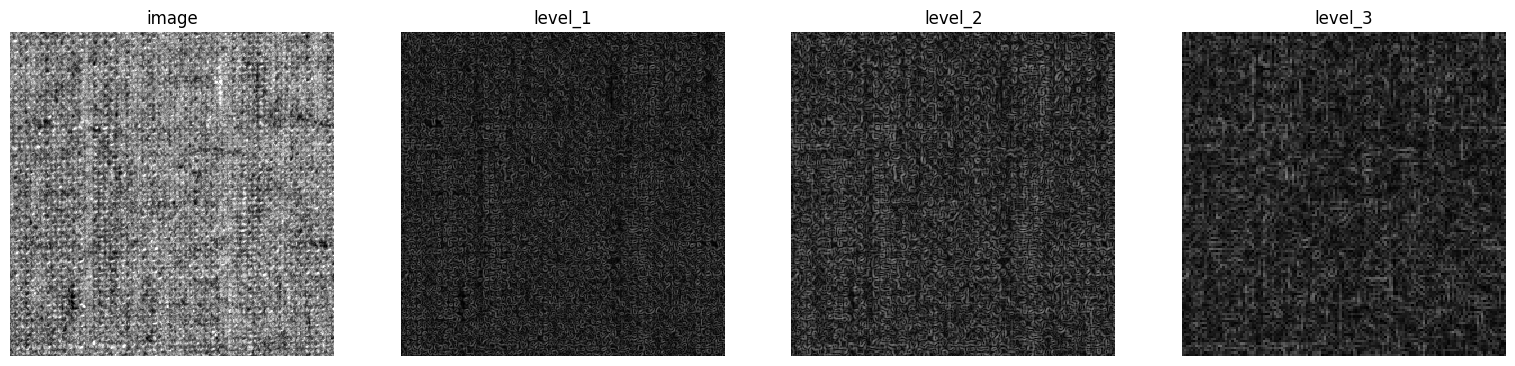

In [ ]:
plot_four_images(X_train, "image","level_1", "level_2", "level_3")

##  Apply equalization, Smoothing, resizing, sobel and get the histograms for the 3 image levels to the testing data



In [ ]:
test = smoothing(test, "image" , "level_1")
test = resizing(test)
test = sobel_(test)
test = hist(test, 'level_1')
test = hist(test, 'level_2')
test = hist(test, 'level_3')
test

image       label  \
0   [[79, 74, 75, 84, 96, 97, 103, 122, 151, 164, ...    cushion1   
1   [[89, 97, 107, 117, 141, 177, 189, 197, 214, 2...    cushion1   
2   [[124, 120, 98, 82, 74, 69, 69, 73, 77, 92, 10...    cushion1   
3   [[99, 97, 102, 113, 120, 116, 108, 113, 115, 1...    cushion1   
4   [[117, 110, 116, 112, 115, 106, 93, 96, 104, 1...    cushion1   
5   [[160, 152, 137, 128, 128, 113, 99, 90, 86, 82...    cushion1   
6   [[85, 82, 79, 82, 92, 100, 94, 84, 86, 103, 11...    cushion1   
7   [[126, 118, 125, 128, 136, 141, 135, 133, 137,...    cushion1   
8   [[103, 99, 94, 100, 108, 108, 112, 117, 119, 1...    cushion1   
9   [[175, 198, 198, 208, 210, 207, 214, 213, 214,...    cushion1   
10  [[148, 134, 155, 136, 133, 91, 84, 107, 91, 11...       seat2   
11  [[157, 139, 169, 155, 147, 155, 199, 204, 177,...       seat2   
12  [[84, 87, 110, 115, 136, 88, 100, 119, 105, 12...       seat2   
13  [[120, 143, 131, 185, 212, 206, 160, 189, 205,...       seat2   
14  [[110, 105, 67, 100, 130, 97, 118, 119, 114, 1...       seat2   
15  [[115, 115, 81, 65, 98, 98, 131, 136, 139, 134...       seat2   
16  [[86, 98, 116, 128, 157, 135, 114, 120, 101, 1...       seat2   
17  [[145, 126, 115, 113, 128, 174, 196, 213, 222,...       seat2   
18  [[121, 93, 74, 78, 105, 133, 140, 112, 119, 88...       seat2   
19  [[195, 174, 192, 213, 189, 175, 125, 76, 82, 1...       seat2   
20  [[120, 132, 144, 147, 154, 162, 169, 175, 162,...       sand1   
21  [[100, 90, 89, 92, 92, 83, 75, 112, 176, 200, ...       sand1   
22  [[125, 121, 116, 116, 125, 134, 130, 109, 84, ...       sand1   
23  [[187, 190, 190, 189, 182, 173, 156, 142, 142,...       sand1   
24  [[169, 159, 144, 139, 139, 142, 129, 111, 107,...       sand1   
25  [[115, 113, 115, 118, 124, 133, 140, 142, 144,...       sand1   
26  [[127, 128, 121, 111, 109, 114, 118, 120, 120,...       sand1   
27  [[99, 104, 104, 106, 108, 108, 116, 120, 118, ...       sand1   
28  [[95, 88, 100, 112, 123, 128, 115, 106, 106, 1...       sand1   
29  [[242, 247, 255, 255, 255, 255, 255, 254, 244,...       sand1   
30  [[75, 73, 72, 73, 73, 71, 71, 72, 68, 68, 69, ...  linsseeds1   
31  [[100, 106, 129, 142, 142, 133, 121, 107, 99, ...  linsseeds1   
32  [[148, 140, 135, 133, 130, 126, 118, 107, 94, ...  linsseeds1   
33  [[165, 176, 187, 195, 200, 209, 214, 218, 222,...  linsseeds1   
34  [[122, 122, 140, 152, 136, 113, 99, 98, 91, 78...  linsseeds1   
35  [[202, 198, 195, 189, 185, 181, 179, 176, 177,...  linsseeds1   
36  [[168, 166, 161, 158, 161, 164, 169, 175, 175,...  linsseeds1   
37  [[132, 143, 155, 150, 126, 85, 65, 65, 66, 67,...  linsseeds1   
38  [[188, 178, 150, 125, 120, 117, 90, 72, 68, 69...  linsseeds1   
39  [[83, 85, 88, 86, 82, 80, 81, 81, 83, 84, 86, ...  linsseeds1   
40  [[113, 94, 83, 70, 58, 55, 52, 41, 39, 48, 60,...      stone1   
41  [[120, 123, 128, 139, 127, 104, 101, 105, 101,...      stone1   
42  [[213, 232, 233, 222, 204, 170, 132, 114, 103,...      stone1   
43  [[122, 114, 114, 98, 89, 101, 120, 125, 110, 1...      stone1   
44  [[103, 107, 113, 113, 103, 97, 96, 104, 114, 1...      stone1   
45  [[142, 147, 166, 179, 180, 179, 179, 179, 181,...      stone1   
46  [[126, 116, 102, 110, 133, 155, 163, 166, 163,...      stone1   
47  [[142, 145, 148, 146, 145, 146, 143, 142, 131,...      stone1   
48  [[138, 137, 130, 117, 109, 115, 129, 134, 148,...      stone1   
49  [[154, 143, 156, 129, 113, 120, 123, 116, 106,...      stone1   
50  [[166, 130, 152, 197, 155, 94, 108, 137, 159, ...     canvas1   
51  [[44, 84, 123, 133, 170, 175, 170, 163, 184, 1...     canvas1   
52  [[123, 150, 196, 196, 203, 196, 159, 145, 130,...     canvas1   
53  [[142, 166, 213, 228, 204, 194, 175, 137, 166,...     canvas1   
54  [[102, 114, 151, 168, 151, 147, 156, 175, 163,...     canvas1   
55  [[87, 152, 193, 181, 171, 191, 183, 87, 38, 14...     canvas1   
56  [[157, 196, 249, 193, 113, 87, 104, 101, 101, ...     canvas1   
57  [[179, 143, 91, 89, 115, 110, 139, 153, 14

##  Plot four images from the testing dataframe

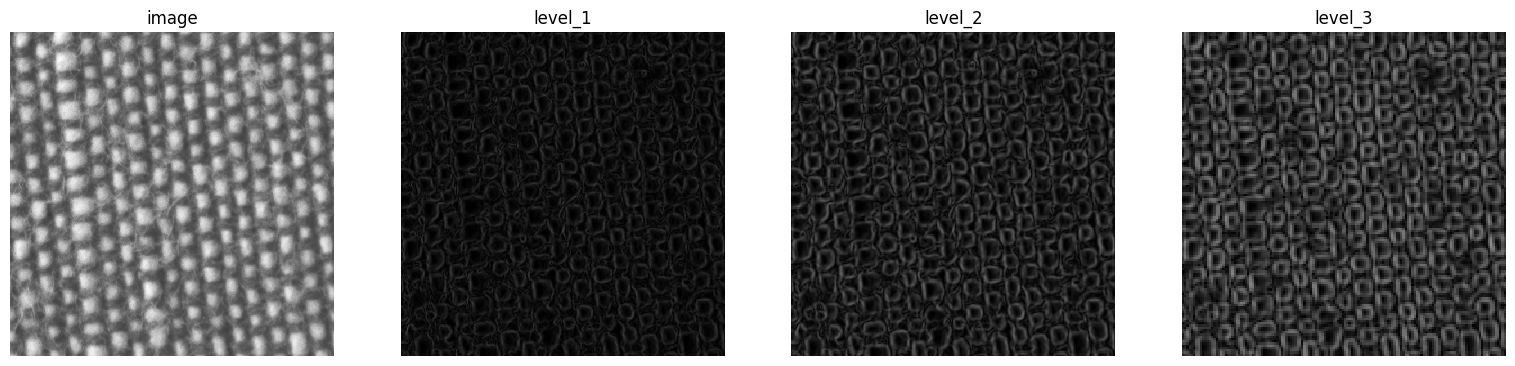

In [ ]:
plot_four_images(test, "image","level_1", "level_2", "level_3")

##  Get the histograms for the 3 image levels to the training data



In [ ]:
X_train = hist(X_train, 'level_1')
X_train = hist(X_train, 'level_2')
X_train = hist(X_train, 'level_3')
X_train

image       label  \
161  [[128, 96, 111, 109, 90, 107, 115, 136, 126, 1...     canvas1   
93   [[103, 99, 93, 85, 78, 76, 76, 76, 79, 91, 108...  linsseeds1   
155  [[104, 94, 82, 119, 159, 132, 157, 154, 146, 1...     canvas1   
18   [[79, 90, 116, 144, 152, 159, 182, 196, 196, 1...    cushion1   
23   [[198, 199, 195, 190, 180, 168, 143, 124, 111,...    cushion1   
..                                                 ...         ...   
7    [[98, 137, 166, 181, 188, 192, 202, 206, 204, ...    cushion1   
79   [[200, 213, 219, 219, 215, 208, 198, 178, 164,...       sand1   
4    [[96, 100, 102, 106, 110, 110, 117, 118, 117, ...    cushion1   
43   [[119, 102, 92, 62, 59, 71, 85, 90, 94, 135, 1...       seat2   
26   [[118, 115, 122, 100, 88, 108, 107, 115, 126, ...    cushion1   

                                               level_1  \
161  [[0.06351760512314919, 0.08622347248109224, 0....   
93   [[0.023711870269118633, 0.04218521894689865, 0...   
155  [[0.04065661402460647, 0.05972491223346034, 0....   
18   [[0.08241661879284647, 0.21376089991275538, 0....   
23   [[0.007005463633577179, 0.01271060815874383, 0...   
..                                                 ...   
7    [[0.12080087752818966, 0.22375389117834696, 0....   
79   [[0.00730113072990234, 0.01278185066827435, 0....   
4    [[0.05652184266191743, 0.058231145606053455, 0...   
43   [[0.0562924700089148, 0.12666109112778492, 0.1...   
26   [[0.010138457678608319, 0.03225208592168752, 0...   

                                               level_2  \
161  [[0.11955301551425263, 0.17433253546145874, 0....   
93   [[0.030267050800320414, 0.05659581075079443, 0...   
155  [[0.14333086757710856, 0.25355536499905534, 0....   
18   [[0.20708712889264536, 0.3812604445858056, 0.2...   
23   [[0.024087940759954816, 0.09024270759859822, 0...   
..                                                 ...   
7    [[0.16437169346988223, 0.23600652586520104, 0....   
79   [[0.01316520129180979, 0.008844907745052913, 0...   
4    [[0.07335617268311435, 0.04494836330105307, 0....   
43   [[0.12339420866146568, 0.16643946619481417, 0....   
26   [[0.08258090410026818, 0.10085674286377834, 0....   

                                               level_3  \
161  [[0.16643379122760654, 0.005868135563355297, 0...   
93   [[0.005071756154856542, 0.14372760002803137, 0...   
155  [[0.08303115016967166, 0.06562826657623666, 0....   
18   [[0.30188287584488904, 0.39499521670132864, 0....   
23   [[0.13391891933483296, 0.38575023369039585, 0....   
..                                                 ...   
7    [[0.1503056706894512, 0.16175559795845135, 0.0...   
79   [[0.043845911847359094, 0.050634169251958246, ...   
4    [[0.008343631041663127, 0.1484973828307317, 0....   
43   [[0.16661027667680164, 0.2509933359570506, 0.3...   
26   [[0.12219173167495467, 0.10567059682329834, 0....   

                                     level_1_histogram  \
161  [81, 174, 301, 366, 476, 533, 629, 740, 830, 8...   
93   [1121, 2461, 3427, 4174, 4852, 5322, 5713, 597...   
155  [70, 133, 206, 315, 402, 476, 549, 637, 751, 7...   
18   [617, 1157, 1365, 1509, 1725, 1846, 1961, 2162...   
23   [507, 960, 1183, 1411, 1609, 1696, 1882, 1971,...   
..                                                 ...   
7    [632, 1127, 1442, 1652, 1826, 2050, 2144, 2190...   
79   [939, 1430, 1804, 1986, 2202, 2375, 2454, 2714...   
4    [528, 960, 1158, 1301, 1554, 1538, 1637, 1825,...   
43   [93, 221, 327, 435, 565, 696, 730, 894, 993, 1...   
26   [705, 1012, 1387, 1493, 1722, 1868, 2007, 2083...   

                                     level_2_histogram  \
161  [11, 32, 43, 77, 96, 109, 127, 140, 158, 189, ...   
93   [131, 296, 429, 593, 690, 771, 895, 911, 984, ...   
155  [11, 37, 53, 63, 81, 92, 124, 142, 161, 197, 1...   
18   [64, 150, 185, 225, 266, 269, 318, 323, 357, 4...   
23   [70, 132, 183, 233, 245, 284, 316, 357, 338, 3...   
..                                                 ...   
7    [76, 185,

##  Get the histograms for the 3 image levels to the validation data



In [ ]:
X_val = hist(X_val, 'level_1')
X_val = hist(X_val, 'level_2')
X_val = hist(X_val, 'level_3')
X_val

image       label  \
15   [[186, 178, 168, 151, 138, 117, 111, 108, 114,...    cushion1   
80   [[150, 144, 142, 147, 150, 145, 142, 127, 85, ...       sand1   
138  [[34, 34, 34, 45, 58, 73, 88, 97, 96, 95, 105,...      stone1   
25   [[184, 185, 184, 181, 177, 160, 148, 131, 128,...    cushion1   
28   [[113, 120, 115, 98, 87, 88, 98, 100, 100, 102...    cushion1   
27   [[80, 90, 93, 93, 93, 93, 88, 86, 83, 87, 98, ...    cushion1   
147  [[63, 66, 67, 79, 81, 68, 63, 64, 75, 93, 96, ...      stone1   
74   [[100, 97, 75, 73, 80, 87, 95, 98, 97, 112, 12...       sand1   
36   [[112, 173, 163, 155, 169, 173, 168, 185, 144,...       seat2   
38   [[126, 126, 136, 178, 187, 163, 178, 184, 187,...       seat2   
96   [[145, 172, 166, 150, 140, 131, 128, 125, 121,...  linsseeds1   
59   [[119, 111, 125, 123, 114, 140, 129, 114, 125,...       seat2   
57   [[128, 101, 74, 76, 92, 103, 88, 78, 106, 139,...       seat2   
145  [[101, 98, 96, 102, 110, 120, 130, 132, 138, 1...      stone1   
164  [[73, 60, 63, 95, 68, 84, 119, 106, 81, 122, 1...     canvas1   
160  [[67, 65, 67, 90, 110, 117, 119, 90, 79, 110, ...     canvas1   
97   [[89, 86, 85, 85, 83, 85, 85, 77, 70, 62, 70, ...  linsseeds1   
169  [[86, 90, 82, 82, 119, 170, 178, 137, 125, 174...     canvas1   
37   [[101, 96, 78, 103, 94, 78, 123, 123, 88, 100,...       seat2   
104  [[191, 175, 176, 202, 202, 174, 138, 137, 138,...  linsseeds1   
170  [[154, 134, 106, 92, 65, 46, 37, 49, 73, 99, 1...     canvas1   
77   [[132, 132, 134, 136, 138, 147, 156, 160, 151,...       sand1   
157  [[86, 89, 84, 81, 98, 113, 121, 148, 166, 148,...     canvas1   
14   [[175, 180, 184, 189, 190, 185, 180, 172, 164,...    cushion1   
126  [[190, 190, 159, 152, 151, 141, 120, 100, 78, ...      stone1   
89   [[180, 163, 130, 110, 110, 122, 120, 110, 105,...       sand1   
103  [[74, 79, 83, 86, 89, 101, 120, 140, 153, 164,...  linsseeds1   
55   [[137, 165, 167, 139, 149, 159, 139, 109, 129,...       seat2   
156  [[176, 174, 162, 160, 155, 125, 95, 97, 85, 10...     canvas1   
92   [[175, 168, 165, 164, 162, 161, 164, 164, 158,...  linsseeds1   
129  [[151, 168, 188, 198, 194, 182, 170, 170, 185,...      stone1   
75   [[95, 105, 112, 123, 125, 99, 92, 94, 97, 89, ...       sand1   
72   [[63, 77, 92, 117, 136, 143, 136, 143, 127, 99...       sand1   
9    [[111, 107, 94, 105, 124, 144, 146, 178, 187, ...    cushion1   
132  [[182, 185, 188, 189, 185, 186, 189, 182, 178,...      stone1   
101  [[184, 188, 194, 198, 201, 201, 196, 192, 198,...  linsseeds1   

                                               level_1  \
15   [[0.01616135930662019, 0.04652911629377068, 0....   
80   [[0.02577070714228172, 0.044402690186796406, 0...   
138  [[0.018053335826800063, 0.020511152892195468, ...   
25   [[0.00965952280663946, 0.010906585571080563, 0...   
28   [[0.020410504981745143, 0.04713940181949001, 0...   
27   [[0.03275715147396002, 0.06302881339213127, 0....   
147  [[0.010184250741011196, 0.01573061138605145, 0...   
74   [[0.037928027470875654, 0.07281262548982224, 0...   
36   [[0.13313542330373837, 0.19785045836055914, 0....   
38   [[0.0769179855245954, 0.11023134610953056, 0.1...   
96   [[0.030493618094124195, 0.01945740562646033, 0...   
59   [[0.01957907567023518, 0.019210193978759883, 0...   
57   [[0.07908824870053133, 0.14927418952930768, 0....   
145  [[0.02939188642483769, 0.03379913747293124, 0....   
164  [[0.05151748872778214, 0.04645238342281721, 0....   
160  [[0.011360475198429048, 0.03201705310636963, 0...   
97   [[0.009047358780883743, 0.014239773298480727, ...   
169  [[0.005685316070788268, 0.027274257379356164, ...   
37   [[0.0551182057500152, 0.06299523863558829, 0.0...   
104  [[0.02457515388386448, 0.025157914779061114, 0...   
170  [[0.09286304993786337, 0.17027653171456206, 0....   
77   [[0.005236611100772459, 0.01481262880799355, 0...   
157  [[0.09182134810397494, 0.10054296336925635, 0....   
14   [[0.015558944298180683, 0.02465516689014032, 0...   
126  [[0

## Training data

### Split the training dataframe into 6 different dataframes grouped by the category

In [ ]:
grouped = X_train.groupby("label")
dataframes = {}

for label, group in grouped:
    dataframes[label] = group

In [ ]:
sand1_train = dataframes['sand1']
seat2_train = dataframes['seat2']
stone1_train = dataframes['stone1']
canvas1_train = dataframes['canvas1']
cushion1_train = dataframes['cushion1']
linsseeds1_train = dataframes['linsseeds1']

### Get the histogram of level 1 for each category dataframe for training data

In [ ]:
sand1_train_hist1 = df_hist(sand1_train , "level_1_histogram")
seat2_train_hist1 = df_hist(seat2_train , "level_1_histogram")
stone1_train_hist1 = df_hist(stone1_train , "level_1_histogram")
canvas1_train_hist1 = df_hist(canvas1_train , "level_1_histogram")
cushion1_train_hist1 = df_hist(cushion1_train , "level_1_histogram")
linsseeds1_train_hist1 = df_hist(linsseeds1_train , "level_1_histogram")

#### Compute the average histogram of level 1 for each category

In [ ]:
seat2_avg_hist_train1 = compute_avg_hist(seat2_train_hist1)
sand1_avg_hist_train1 = compute_avg_hist(sand1_train_hist1)
stone1_avg_hist_train1 = compute_avg_hist(stone1_train_hist1)
canvas1_avg_hist_train1 = compute_avg_hist(canvas1_train_hist1)
cushion1_avg_hist_train1 = compute_avg_hist(cushion1_train_hist1)
linsseeds1_avg_hist_train1 = compute_avg_hist(linsseeds1_train_hist1)


In [ ]:
train_hist1 = df_hist(X_train , "level_1_histogram")
train_hist1["label"] = X_train["label"].values

### Get the histogram of level 2 for each category dataframe for training data

In [ ]:
sand1_train_hist2 = df_hist(sand1_train , "level_2_histogram")
seat2_train_hist2 = df_hist(seat2_train , "level_2_histogram")
stone1_train_hist2 = df_hist(stone1_train , "level_2_histogram")
canvas1_train_hist2 = df_hist(canvas1_train , "level_2_histogram")
cushion1_train_hist2 = df_hist(cushion1_train , "level_2_histogram")
linsseeds1_train_hist2 = df_hist(linsseeds1_train , "level_2_histogram")

#### Compute the average histogram of level 2 for each category

In [ ]:
seat2_avg_hist_train2 = compute_avg_hist(seat2_train_hist2)
sand1_avg_hist_train2 = compute_avg_hist(sand1_train_hist2)
stone1_avg_hist_train2 = compute_avg_hist(stone1_train_hist2)
canvas1_avg_hist_train2 = compute_avg_hist(canvas1_train_hist2)
cushion1_avg_hist_train2 = compute_avg_hist(cushion1_train_hist2)
linsseeds1_avg_hist_train2 = compute_avg_hist(linsseeds1_train_hist2)

In [ ]:
train_hist2 = df_hist(X_train , "level_2_histogram")
train_hist2["label"] = X_train["label"].values

### Get the histogram of level 3 for each category dataframe for training data

In [ ]:
sand1_train_hist3 = df_hist(sand1_train , "level_3_histogram")
seat2_train_hist3 = df_hist(seat2_train , "level_3_histogram")
stone1_train_hist3 = df_hist(stone1_train , "level_3_histogram")
canvas1_train_hist3 = df_hist(canvas1_train , "level_3_histogram")
cushion1_train_hist3 = df_hist(cushion1_train , "level_3_histogram")
linsseeds1_train_hist3 = df_hist(linsseeds1_train , "level_3_histogram")

#### Compute the average histogram of level 3 for each category

In [ ]:
seat2_avg_hist_train3 = compute_avg_hist(seat2_train_hist3)
sand1_avg_hist_train3 = compute_avg_hist(sand1_train_hist3)
stone1_avg_hist_train3 = compute_avg_hist(stone1_train_hist3)
canvas1_avg_hist_train3 = compute_avg_hist(canvas1_train_hist3)
cushion1_avg_hist_train3 = compute_avg_hist(cushion1_train_hist3)
linsseeds1_avg_hist_train3 = compute_avg_hist(linsseeds1_train_hist3)

In [ ]:
train_hist3 = df_hist(X_train , "level_3_histogram")
train_hist3["label"] = X_train["label"].values

## Validation data

### Get the histogram of level 1 for validation data

In [ ]:
val_hist1 = df_hist(X_val , "level_1_histogram")
val_hist1["label"] = X_val["label"].values

### Get the histogram of level 2 for validation data

In [ ]:
val_hist2 = df_hist(X_val , "level_2_histogram")
val_hist2["label"] = X_val["label"].values

### Get the histogram of level 3 for validation data

In [ ]:
val_hist3 = df_hist(X_val , "level_3_histogram")
val_hist3["label"] = X_val["label"].values

## Testing data

### Get the histogram of level 1 for testing data

In [ ]:
test_hist1 = df_hist(test , "level_1_histogram")
test_hist1["label"] = test["label"].values

### Get the histogram of level 2 for testing data

In [ ]:
test_hist2 = df_hist(test , "level_2_histogram")
test_hist2["label"] = test["label"].values

### Get the histogram of level 3 for testing data

In [ ]:
test_hist3 = df_hist(test , "level_3_histogram")
test_hist3["label"] = test["label"].values

# 1.3- Learning free classification

## Plot the KDEs for each category of the training data

In [ ]:
data = {
    'Seat2': seat2_avg_hist_train1,
    'Sand1': sand1_avg_hist_train1,
    'Stone1': stone1_avg_hist_train1,
    'Canvas1': canvas1_avg_hist_train1,
    'Cushion1': cushion1_avg_hist_train1,
    'Linsseeds1': linsseeds1_avg_hist_train1,
}

df = pd.DataFrame(data)


In [ ]:
df

Seat2        Sand1       Stone1     Canvas1     Cushion1  \
0     79.666667   844.791667   417.583333   62.958333   606.041667   
1    205.250000  1290.625000   879.250000  152.000000  1068.750000   
2    332.083333  1517.333333  1198.250000  246.000000  1366.541667   
3    461.500000  1725.083333  1471.250000  332.458333  1594.125000   
4    568.625000  1884.416667  1700.750000  418.416667  1776.291667   
..          ...          ...          ...         ...          ...   
251    0.333333     0.791667     0.750000    0.541667     0.500000   
252    0.500000     0.791667     0.625000    0.708333     0.416667   
253    0.166667     0.916667     0.458333    0.500000     0.625000   
254    0.250000     0.375000     0.333333    0.375000     0.250000   
255    1.291667     1.500000     1.375000    1.083333     1.250000   

      Linsseeds1  
0    1241.166667  
1    2507.291667  
2    3330.791667  
3    4055.958333  
4    4607.750000  
..           ...  
251     2.041667  
252     1.541667  
253     1.041667  
254     0.708333  
255     1.958333  

[256 rows x 6 columns]

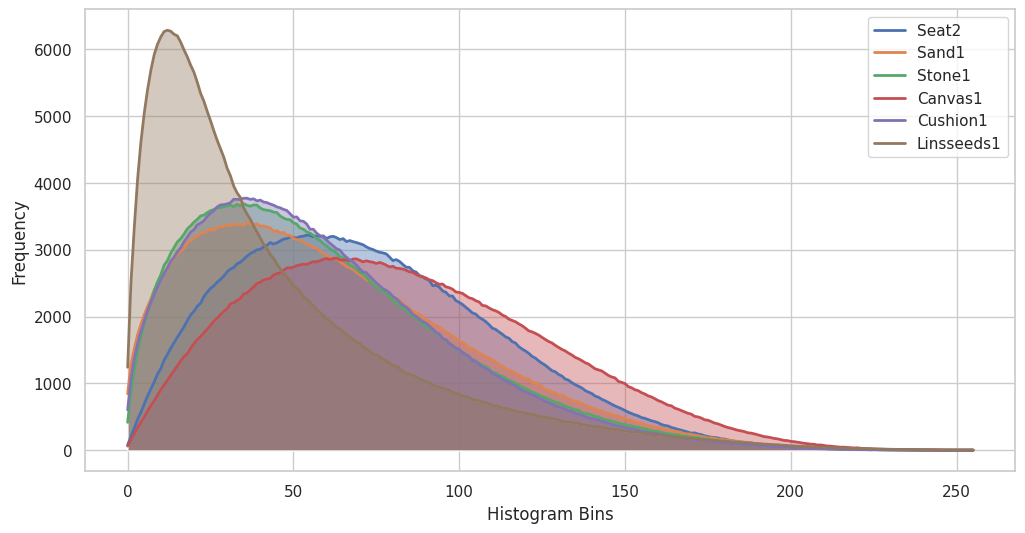

In [ ]:
def plot_hist(df , kde_data=None, kde_label=None , true=None , pred=None):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    if kde_data is not None:
        plt.plot(np.arange(256), kde_data, label=kde_label, linewidth=2)
        plt.title("True labes :{} \n Predicted labels :{}".format(true, pred))
    for label, data in df.items():
        plt.plot(data, label=label, linewidth=2)
        plt.fill_between(np.arange(256), data, alpha=0.4)

    plt.xlabel('Histogram Bins')
    plt.ylabel('Frequency')
    # plt.title('KDE Plot for Misclassified Image and Class Averages')
    plt.legend()
    plt.show()

plot_hist(df)

## Concatenate the average histograme of level 1 for each category into one dataframe

In [ ]:
dataframes = [seat2_avg_hist_train1, sand1_avg_hist_train1, stone1_avg_hist_train1, canvas1_avg_hist_train1, cushion1_avg_hist_train1, linsseeds1_avg_hist_train1]
avg_df1 = pd.concat(dataframes, axis=1 ).transpose()
avg_df1["label"] = ['Seat2', 'Sand1', 'Stone1', 'Canvas1' , 'Cushion1' ,'Linsseeds1']

## Concatenate the average histograme of level 2 for each category into one dataframe

In [ ]:
dataframes = [seat2_avg_hist_train2, sand1_avg_hist_train2, stone1_avg_hist_train2, canvas1_avg_hist_train2, cushion1_avg_hist_train2, linsseeds1_avg_hist_train2]
avg_df2 = pd.concat(dataframes, axis=1 ).transpose()
avg_df2["label"] = ['Seat2', 'Sand1', 'Stone1', 'Canvas1' , 'Cushion1' ,'Linsseeds1']


## Concatenate the average histograme of level 3 for each category into one dataframe

In [ ]:
dataframes = [seat2_avg_hist_train3, sand1_avg_hist_train3, stone1_avg_hist_train3, canvas1_avg_hist_train3, cushion1_avg_hist_train3, linsseeds1_avg_hist_train3]
avg_df3 = pd.concat(dataframes, axis=1 ).transpose()
avg_df3["label"] = ['Seat2', 'Sand1', 'Stone1', 'Canvas1' , 'Cushion1' ,'Linsseeds1']


## Use the chi squared to measure the distances between the images and the 6 average histogram of each category

In [ ]:
class_map = {0: 'seat2', 1: 'sand1' , 2: 'stone1' , 3: 'canvas1' , 4: 'cushion1' , 5: 'linsseeds1'}

def chi_squared_distance(df, avg_df1):
    prediction = []
    temp = df.drop('label', axis=1)
    hist2 = avg_df1.drop('label', axis=1)
    for j in range(len(temp)):
        min_distance = float('inf')  # Initialize with a large value
        predicted_class = None

        for i in range(len(hist2)):
            chi_squared = np.sum((temp.iloc[j] - hist2.iloc[i])**2 / (temp.iloc[j] + hist2.iloc[i] + np.finfo(float).eps))

            if chi_squared < min_distance:
                min_distance = chi_squared
                predicted_class = class_map[i]

        prediction.append(predicted_class)

    true_labels = df['label']
    predicted_labels = pd.Series(prediction)

    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, average='macro')
    precision = precision_score(true_labels, predicted_labels, average='macro')

    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")

    # Visualize a KDE plot for a misclassified sample
    misclassified_index = (true_labels != predicted_labels).idxmax()
    misclassified_data = df.loc[misclassified_index]
    misclassified_histogram = misclassified_data.drop('label')
    true_label = true_labels[misclassified_index]
    predicted_label = predicted_labels[misclassified_index]

    hist2.index = hist2.index.map(class_map)
    plot_hist(hist2.transpose(),misclassified_histogram, kde_label='KDE (Misclassified)' , true = true_label , pred = predicted_label)


### Evaluate the metrics over training and validation data and visualize the misclassified samples based on the chi squared distance

Metrics for training data based on chi squared distance

Accuracy: 0.875
Recall: 0.8749999999999999
Precision: 0.8825641025641026


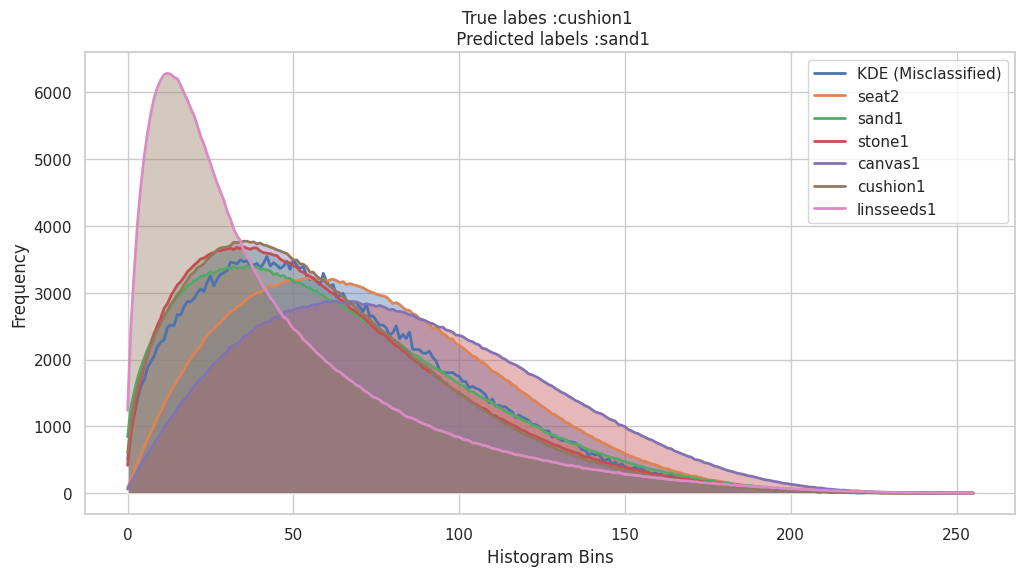


--------------------------------------

Metrics for validation data based on chi squared distance

Accuracy: 0.9166666666666666
Recall: 0.9166666666666666
Precision: 0.9246031746031745


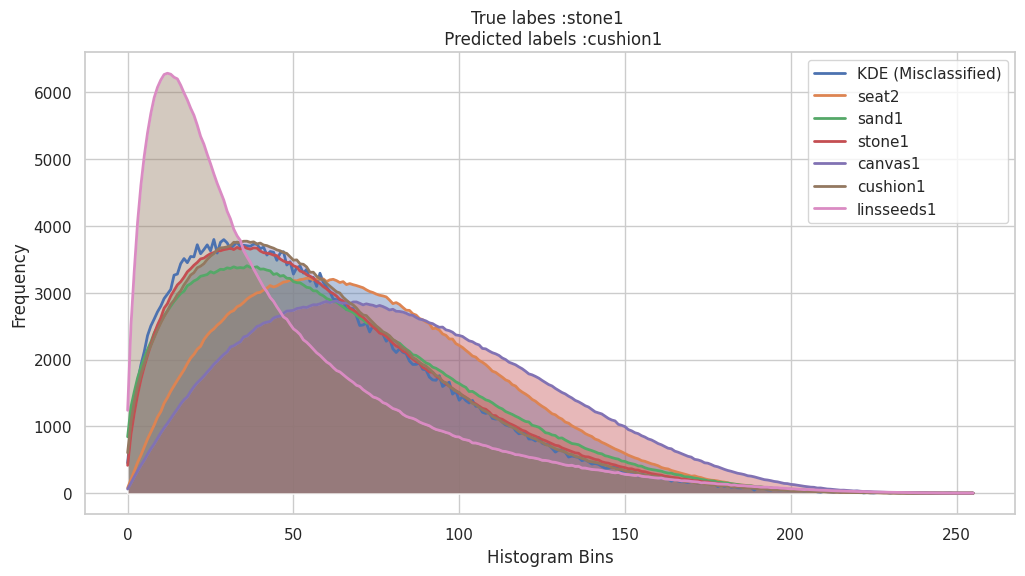


--------------------------------------



In [ ]:
print("Metrics for training data based on chi squared distance")
print()
chi_squared_distance(train_hist1, avg_df1)
print()
print("--------------------------------------")
print()
print("Metrics for validation data based on chi squared distance")
print()
chi_squared_distance(val_hist1, avg_df1)
print()
print("--------------------------------------")
print()

##  Use the euclidean distance to measure the distances between the images and the 6 average histogram of each category

In [ ]:
def euclidean_distance(df, avg_df1):
    prediction = []
    temp = df.drop('label', axis=1)
    hist2 = avg_df1.drop('label', axis=1)
    for j in range(len(temp)):
        min_distance = float('inf')  # Initialize with a large value
        predicted_class = None

        for i in range(len(hist2)):
            euclidean = np.sqrt(np.sum((temp.iloc[j] - hist2.iloc[i])**2))

            if euclidean < min_distance:
                min_distance = euclidean
                predicted_class = class_map[i]

        prediction.append(predicted_class)

    true_labels = df['label']
    predicted_labels = pd.Series(prediction)

    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, average='macro')
    precision = precision_score(true_labels, predicted_labels, average='macro')

    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")

    # Visualize a KDE plot for a misclassified sample
    misclassified_index = (true_labels != predicted_labels).idxmax()
    misclassified_data = df.loc[misclassified_index]
    misclassified_histogram = misclassified_data.drop('label')
    true_label = true_labels[misclassified_index]
    predicted_label = predicted_labels[misclassified_index]

    hist2.index = hist2.index.map(class_map)
    plot_hist(hist2.transpose(),misclassified_histogram, kde_label='KDE (Misclassified)' , true = true_label , pred = predicted_label)


### Evaluate the metrics over training and validation data and visualize the misclassified samples based on the euclidean distance

Metrics for training data based on Euclidean distance

Accuracy: 0.9027777777777778
Recall: 0.9027777777777777
Precision: 0.9133333333333332


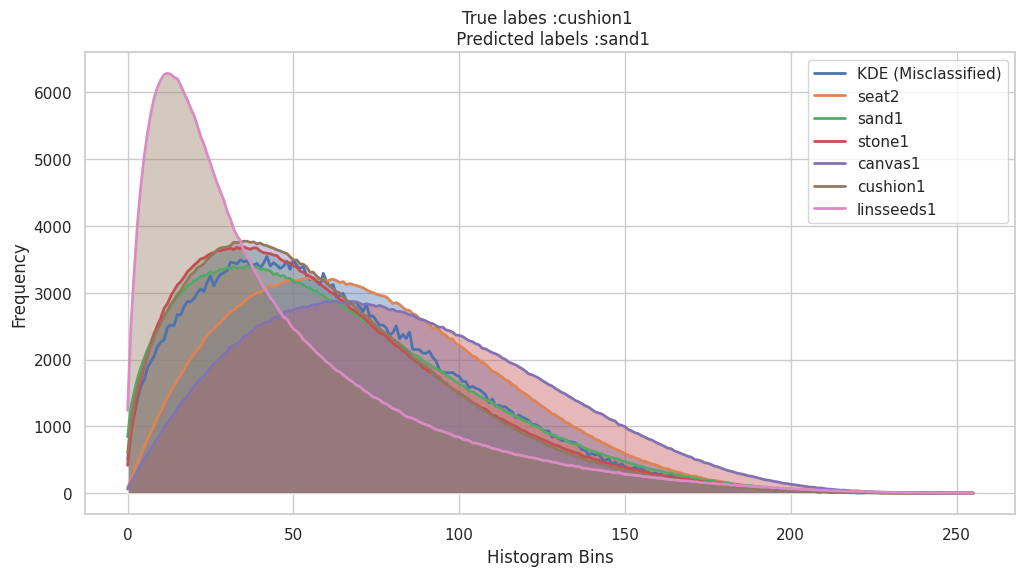


--------------------------------------

Metrics for validation data based on Euclidean distance

Accuracy: 0.9444444444444444
Recall: 0.9444444444444445
Precision: 0.9484126984126985


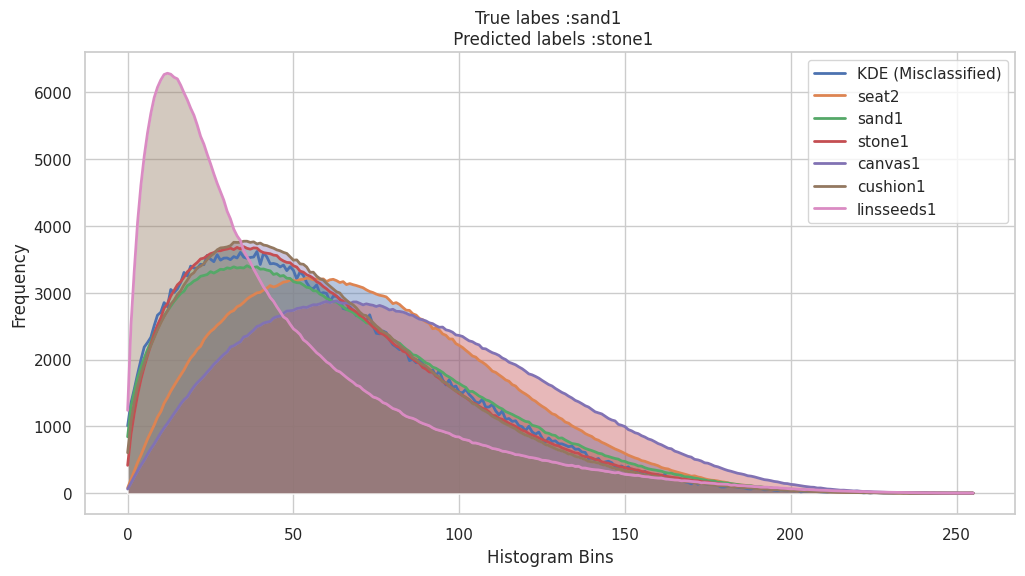


--------------------------------------



In [ ]:
print("Metrics for training data based on Euclidean distance")
print()
euclidean_distance(train_hist1, avg_df1)
print()
print("--------------------------------------")
print()
print("Metrics for validation data based on Euclidean distance")
print()
euclidean_distance(val_hist1, avg_df1)
print()
print("--------------------------------------")
print()


## Use the correlation coefficient to measure the distances between the images and the 6 average histogram of each category

In [ ]:
def corr_coefficient(df, avg_df1):
    prediction = []
    temp = df.drop('label', axis=1)
    hist2 = avg_df1.drop('label', axis=1)

    for j in range(len(temp)):
        min_distance = float('inf')
        predicted_class = None

        for i in range(len(hist2)):
            correlation = np.sum((temp.iloc[j] - hist2.iloc[i])**2 / (temp.iloc[j] + hist2.iloc[i] + np.finfo(float).eps))

            if correlation < min_distance:
                min_distance = correlation
                predicted_class = class_map[i]

        prediction.append(predicted_class)

    true_labels = df['label']
    predicted_labels = pd.Series(prediction)

    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, average='macro')
    precision = precision_score(true_labels, predicted_labels, average='macro')

    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")

    misclassified_index = (true_labels != predicted_labels).idxmax()
    misclassified_data = df.loc[misclassified_index]
    misclassified_histogram = misclassified_data.drop('label')
    true_label = true_labels[misclassified_index]
    predicted_label = predicted_labels[misclassified_index]

    hist2.index = hist2.index.map(class_map)
    plot_hist(hist2.transpose(),misclassified_histogram, kde_label='(Misclassified)' , true = true_label , pred = predicted_label)


### Evaluate the metrics over training and validation data and visualize the misclassified samples based on the correlation coefficient

Metrics for training data based on correlation coefficient

Accuracy: 0.875
Recall: 0.8749999999999999
Precision: 0.8825641025641026


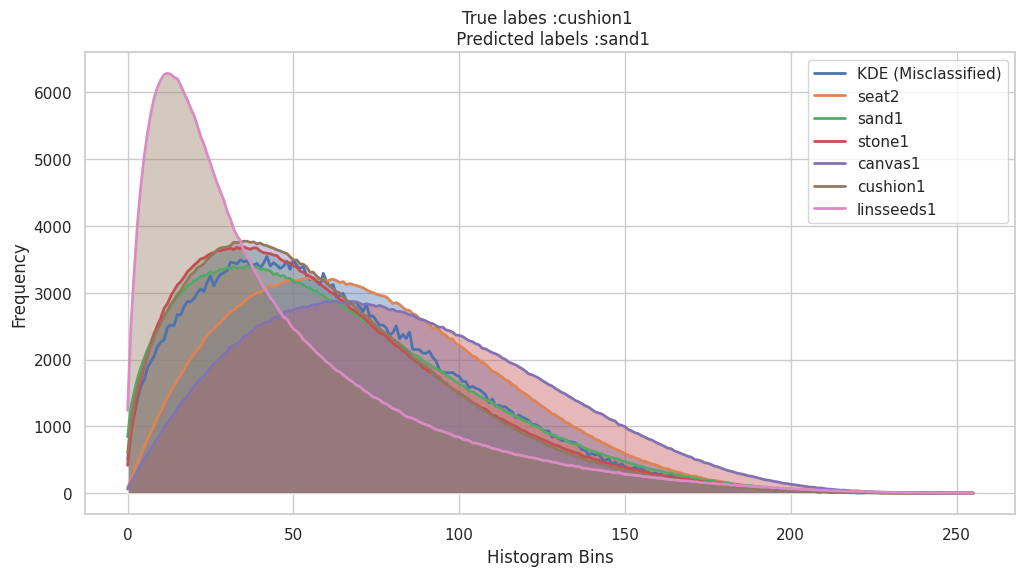


--------------------------------------

Metrics for validation data based on correlation coefficient

Accuracy: 0.9166666666666666
Recall: 0.9166666666666666
Precision: 0.9246031746031745


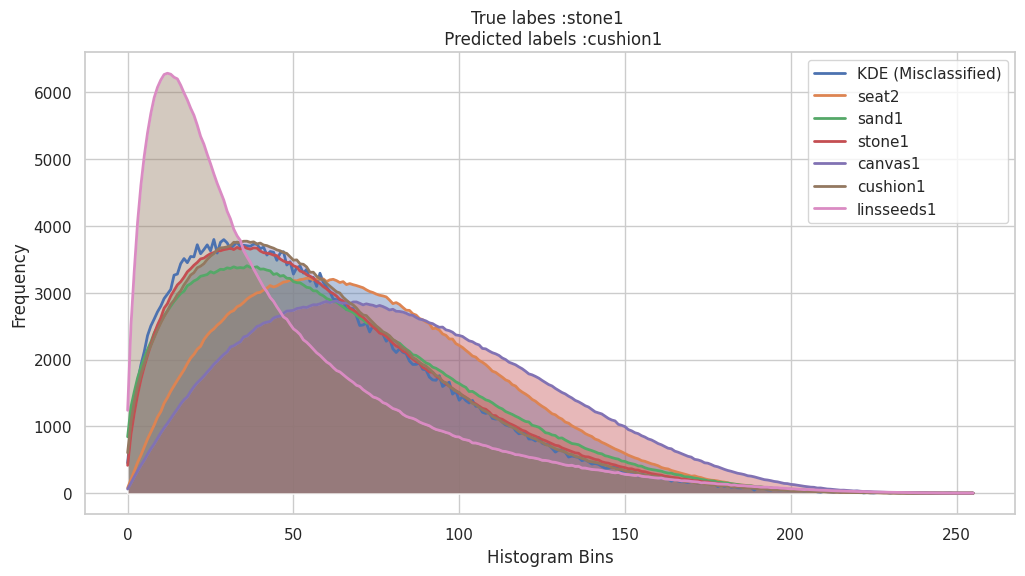


--------------------------------------



In [ ]:
print("Metrics for training data based on correlation coefficient")
print()
corr_coefficient(train_hist1, avg_df1)
print()
print("--------------------------------------")
print()
print("Metrics for validation data based on correlation coefficient")
print()
corr_coefficient(val_hist1, avg_df1)
print()
print("--------------------------------------")
print()


# **According to the metrics for training, validation and testing data, the Euclidean distance is a litle bit better than the chi squared and correlation coefficient distances to measure the distances between the images and the 6 average histogram of each category**

# 1.4- Learning-Based Classification

## Flatten the 3 training levels of histogram images into one dataframe

In [ ]:
label_encoder = LabelEncoder()

train_hist1_new = train_hist1.drop(columns=['label'])
train_hist2_new = train_hist2.drop(columns=['label'])
train_hist3_new = train_hist3.drop(columns=['label'])

concatenated_features = pd.concat([train_hist1_new , train_hist2_new, train_hist3_new], axis=1)
concatenated_train_df = pd.concat([concatenated_features, train_hist1['label']], axis=1)
num_features = concatenated_train_df.shape[1]

new_column_names = [f'{i}' for i in range(num_features)]
concatenated_train_df.columns = new_column_names
concatenated_train_df.rename(columns={new_column_names[-1]: "label"}, inplace=True)


concatenated_train_df['label'] = label_encoder.fit_transform(concatenated_train_df['label'])

In [ ]:
concatenated_train_df

0     1     2     3     4     5     6     7     8     9  ...  759  \
0      81   174   301   366   476   533   629   740   830   875  ...    0   
1    1121  2461  3427  4174  4852  5322  5713  5971  6191  6395  ...    2   
2      70   133   206   315   402   476   549   637   751   798  ...    0   
3     617  1157  1365  1509  1725  1846  1961  2162  2129  2336  ...    1   
4     507   960  1183  1411  1609  1696  1882  1971  2053  2194  ...    1   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...  ...   
139   632  1127  1442  1652  1826  2050  2144  2190  2413  2485  ...    1   
140   939  1430  1804  1986  2202  2375  2454  2714  2704  2811  ...    2   
141   528   960  1158  1301  1554  1538  1637  1825  1849  1949  ...    0   
142    93   221   327   435   565   696   730   894   993  1124  ...    0   
143   705  1012  1387  1493  1722  1868  2007  2083  2173  2433  ...    2   

     760  761  762  763  764  765  766  767  label  
0      0    0    0    0    0    0    0    1      0  
1      0    2    3    3    3    1    4    2      2  
2      0    0    0    0    0    0    0    1      0  
3      0    1    0    0    0    1    0    2      1  
4      2    6    1    0    1    2    2    1      1  
..   ...  ...  ...  ...  ...  ...  ...  ...    ...  
139    0    0    2    1    1    1    1    2      1  
140    1    0    2    0    1    2    0    1      3  
141    1    0    0    1    0    1    0    1      1  
142    1    0    0    0    1    0    0    1      4  
143    0    2    2    0    0    0    0    2      1  

[144 rows x 769 columns]

## Flatten the 3 validation levels of histogram images into one dataframe

In [ ]:
val_hist1_new = val_hist1.drop(columns=['label'])
val_hist2_new = val_hist2.drop(columns=['label'])
val_hist3_new = val_hist3.drop(columns=['label'])

concatenated_features = pd.concat([val_hist1_new, val_hist2_new, val_hist3_new], axis=1)
concatenated_val_df = pd.concat([concatenated_features, val_hist1['label']], axis=1)
num_features = concatenated_val_df.shape[1]

new_column_names = [f'{i}' for i in range(num_features)]
concatenated_val_df.columns = new_column_names
concatenated_val_df.rename(columns={new_column_names[-1]: "label"}, inplace=True)

concatenated_val_df['label'] = label_encoder.transform(concatenated_val_df['label'])

## Flatten the 3 testing levels of histogram images into one dataframe

In [ ]:
test_hist1_new = test_hist1.drop(columns=['label'])
test_hist2_new = test_hist2.drop(columns=['label'])
test_hist3_new = test_hist3.drop(columns=['label'])

concatenated_features = pd.concat([test_hist1_new, test_hist2_new, test_hist3_new], axis=1)
concatenated_test_df = pd.concat([concatenated_features, test_hist1['label']], axis=1)
num_features = concatenated_test_df.shape[1]

new_column_names = [f'{i}' for i in range(num_features)]
concatenated_test_df.columns = new_column_names
concatenated_test_df.rename(columns={new_column_names[-1]: "label"}, inplace=True)

concatenated_test_df['label'] = label_encoder.transform(concatenated_test_df['label'])

## split the train, validation and test data

In [ ]:
X_train = concatenated_train_df.drop('label', axis=1)
y_train = concatenated_train_df['label']
X_val = concatenated_val_df.drop('label', axis=1)
y_val = concatenated_val_df['label']
X_test = concatenated_test_df.drop('label', axis=1)
y_test = concatenated_test_df['label']

## Build the model

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model and evaluate the metrics over training and validation data

Epoch 1/100
5/5 [==============================] - 2s 97ms/step - loss: 564.5915 - accuracy: 0.2014 - val_loss: 72.2564 - val_accuracy: 0.3889
Epoch 2/100
5/5 [==============================] - 0s 29ms/step - loss: 55.3421 - accuracy: 0.4306 - val_loss: 17.3823 - val_accuracy: 0.4722
Epoch 3/100
5/5 [==============================] - 0s 42ms/step - loss: 15.9745 - accuracy: 0.4306 - val_loss: 10.8267 - val_accuracy: 0.4167
Epoch 4/100
5/5 [==============================] - 0s 37ms/step - loss: 14.1283 - accuracy: 0.4375 - val_loss: 10.0429 - val_accuracy: 0.6389
Epoch 5/100
5/5 [==============================] - 0s 23ms/step - loss: 11.0955 - accuracy: 0.5000 - val_loss: 9.8378 - val_accuracy: 0.6389
Epoch 6/100
5/5 [==============================] - 0s 28ms/step - loss: 7.9197 - accuracy: 0.5833 - val_loss: 21.0187 - val_accuracy: 0.3611
Epoch 7/100
5/5 [==============================] - 0s 36ms/step - loss: 15.3240 - accuracy: 0.5278 - val_loss: 11.6643 - val_accuracy: 0.7778
Epoch 8

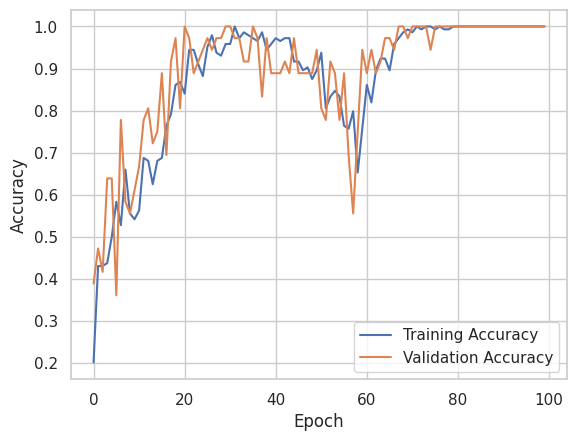

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))


y_pred = model.predict(X_val)
y_pred_class = tf.argmax(y_pred, axis=1).numpy()

accuracy = accuracy_score(y_val, y_pred_class)
recall = recall_score(y_val, y_pred_class, average='macro')
precision = precision_score(y_val, y_pred_class, average='macro')

print()
print()
print(f"Validation data metrics:")
print()
print(f"Validation Accuracy: {accuracy}")
print(f"Validation Recall: {recall}")
print(f"Validation Precision: {precision}")

y_pred = model.predict(X_train)
y_pred_class = tf.argmax(y_pred, axis=1).numpy()

accuracy = accuracy_score(y_train, y_pred_class)
recall = recall_score(y_train, y_pred_class, average='macro')
precision = precision_score(y_train, y_pred_class, average='macro')
print("---------------------------------------")
print()
print()
print(f"Training data metrics:")
print()
print(f"Training Accuracy: {accuracy}")
print(f"Training Recall: {recall}")
print(f"Training Precision: {precision}")
print()
print()
print("---------------------------------------")
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 1.5- Classification Comparison

## Evaluate the multi layer perceptron over the testing data

In [ ]:
y_pred = model.predict(X_test)
y_pred_class = tf.argmax(y_pred, axis=1).numpy()

accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class, average='macro')
precision = precision_score(y_test, y_pred_class, average='macro')
print()
print()
print(f"Testing data metrics:")
print()
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Recall: {recall}")
print(f"Testing Precision: {precision}")
print()
print()

2/2 [==============================] - 0s 8ms/step


Testing data metrics:

Testing Accuracy: 0.95
Testing Recall: 0.9500000000000001
Testing Precision: 0.9570707070707072




## Evaluate the chi squared distance , correlation coefficient , euclidean distance over the testing data

Metrics for Testing data based on Chi Squared  distance

Accuracy: 0.8333333333333334
Recall: 0.8333333333333334
Precision: 0.8472222222222222


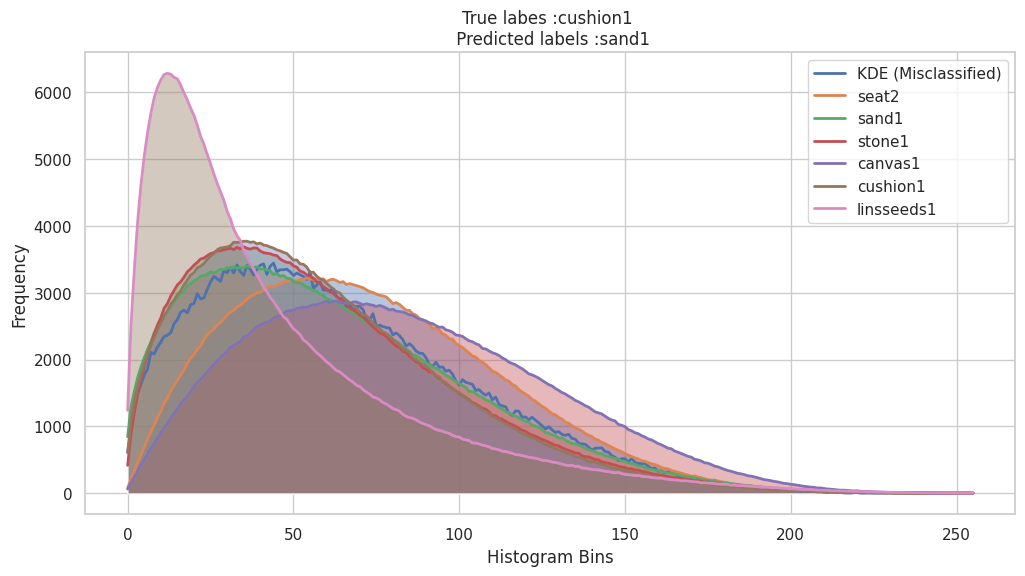


--------------------------------------

Metrics for Testing data based on Euclidean distance

Accuracy: 0.8666666666666667
Recall: 0.8666666666666667
Precision: 0.8778166278166278


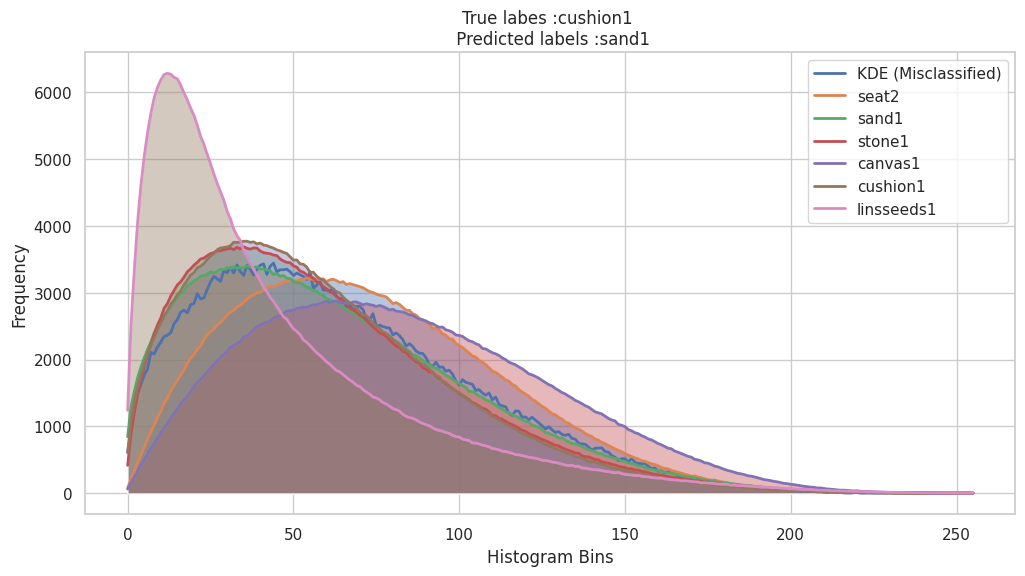


--------------------------------------

Metrics for Testing data based on Correlation Coefficient

Accuracy: 0.8333333333333334
Recall: 0.8333333333333334
Precision: 0.8472222222222222


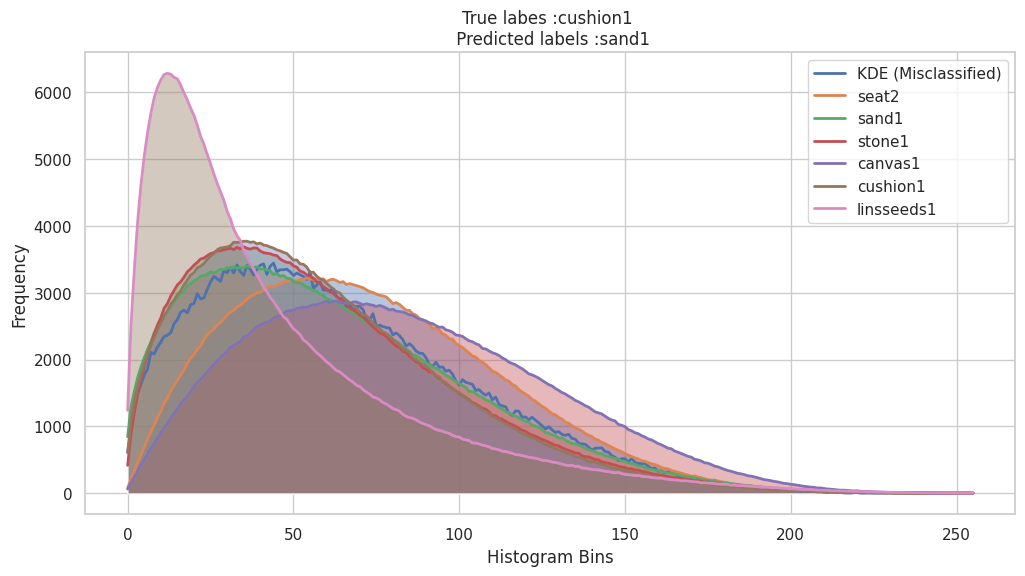

In [ ]:
print("Metrics for Testing data based on Chi Squared  distance")
print()
chi_squared_distance(test_hist1, avg_df1)
print()
print("--------------------------------------")
print()
print("Metrics for Testing data based on Euclidean distance")
print()
euclidean_distance(test_hist1, avg_df1)
print()
print("--------------------------------------")
print()
print("Metrics for Testing data based on Correlation Coefficient")
print()
corr_coefficient(test_hist1, avg_df1)

# **According to the results over the testing data it is obvious that the multi layer perceptron model is way better than the other distance metrics but in return the MLP model take more training and prediction time than the distance metrics**

# 1.6- Improved Classification

## Level 2

### Plot the KDEs for each category of the training data

In [ ]:
data = {
    'Seat2': seat2_avg_hist_train2,
    'Sand1': sand1_avg_hist_train2,
    'Stone1': stone1_avg_hist_train2,
    'Canvas1': canvas1_avg_hist_train2,
    'Cushion1': cushion1_avg_hist_train2,
    'Linsseeds1': linsseeds1_avg_hist_train2,
}

df = pd.DataFrame(data)


In [ ]:
df

Seat2       Sand1      Stone1    Canvas1    Cushion1  Linsseeds1
0    14.541667   91.500000   47.958333  15.708333   75.333333  136.166667
1    31.416667  154.291667  109.708333  30.958333  145.500000  298.375000
2    48.750000  193.875000  158.875000  47.208333  198.041667  434.416667
3    62.541667  226.750000  210.708333  66.125000  246.416667  549.333333
4    80.416667  257.000000  251.041667  80.875000  279.916667  641.291667
..         ...         ...         ...        ...         ...         ...
251   0.541667    0.500000    0.375000   0.291667    0.375000    0.875000
252   0.250000    0.500000    0.416667   0.291667    0.291667    0.666667
253   0.416667    0.125000    0.125000   0.458333    0.375000    0.458333
254   0.208333    0.250000    0.375000   0.208333    0.166667    0.416667
255   1.083333    1.291667    1.083333   1.208333    1.250000    1.500000

[256 rows x 6 columns]

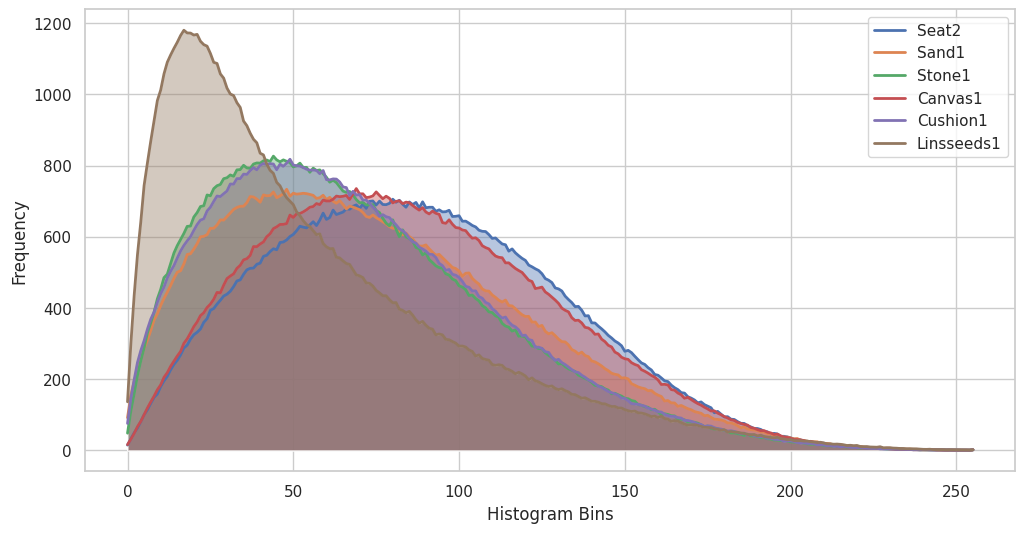

In [ ]:
plot_hist(df)

### Evaluate the metrics over training and validation data and visualize the misclassified samples based on the chi squared distance

Metrics for training data based on chi squared distance

Accuracy: 0.7569444444444444
Recall: 0.7569444444444445
Precision: 0.7312385823894777


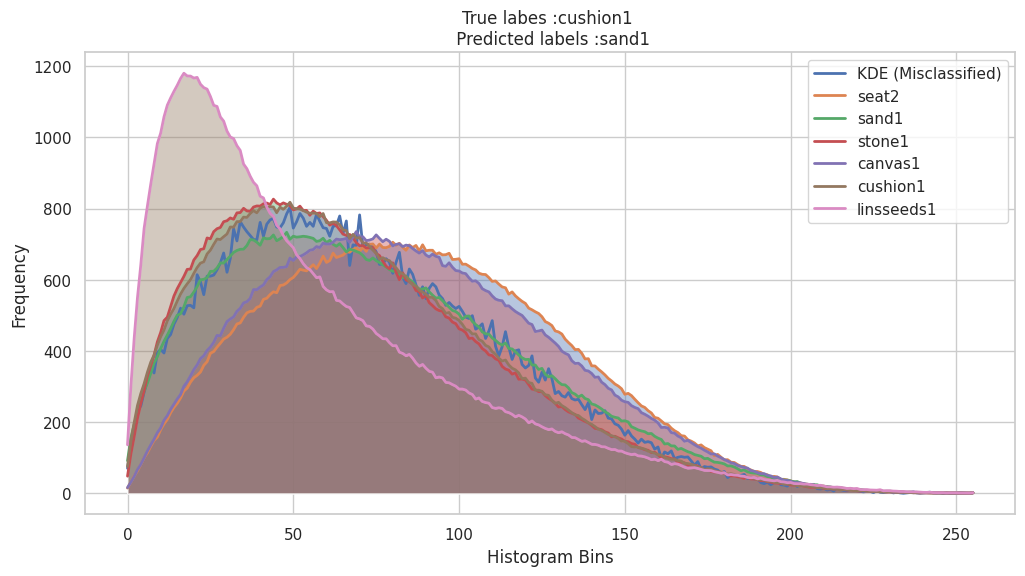


--------------------------------------

Metrics for validation data based on chi squared distance

Accuracy: 0.7777777777777778
Recall: 0.7777777777777778
Precision: 0.6694444444444444


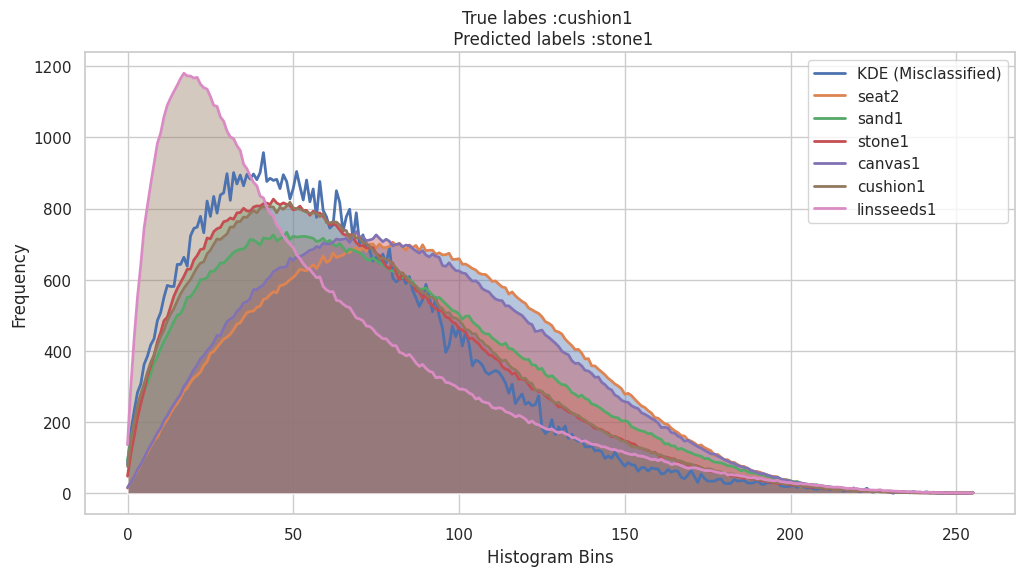


--------------------------------------



In [ ]:
print("Metrics for training data based on chi squared distance")
print()
chi_squared_distance(train_hist2, avg_df2)
print()
print("--------------------------------------")
print()
print("Metrics for validation data based on chi squared distance")
print()
chi_squared_distance(val_hist2, avg_df2)
print()
print("--------------------------------------")
print()

### Evaluate the metrics over training and validation data and visualize the misclassified samples based on the euclidean distance

Metrics for training data based on Euclidean distance distance

Accuracy: 0.7361111111111112
Recall: 0.7361111111111112
Precision: 0.7101613673843689


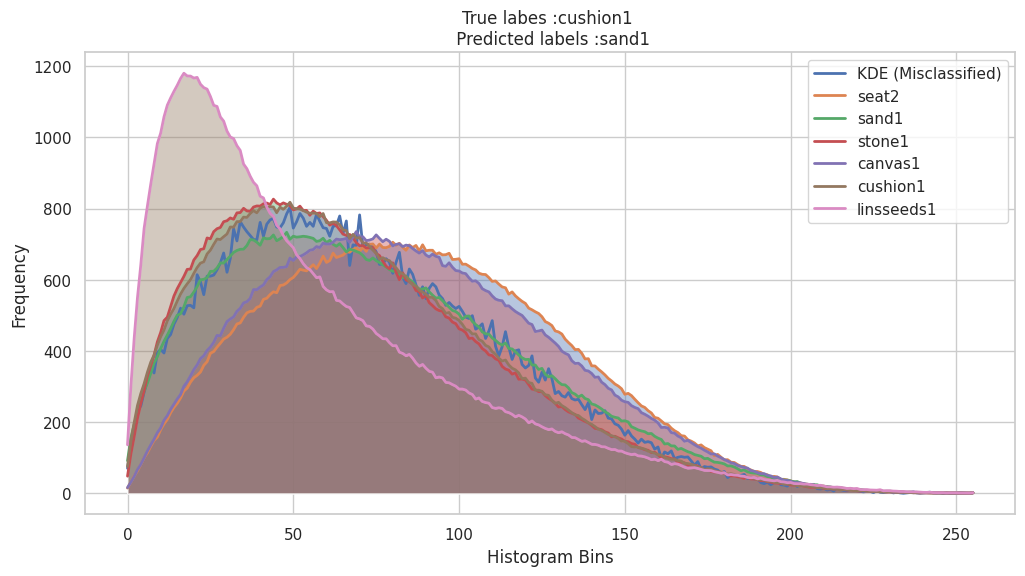


--------------------------------------

Metrics for validation data based on Euclidean distance distance

Accuracy: 0.75
Recall: 0.75
Precision: 0.6620370370370371


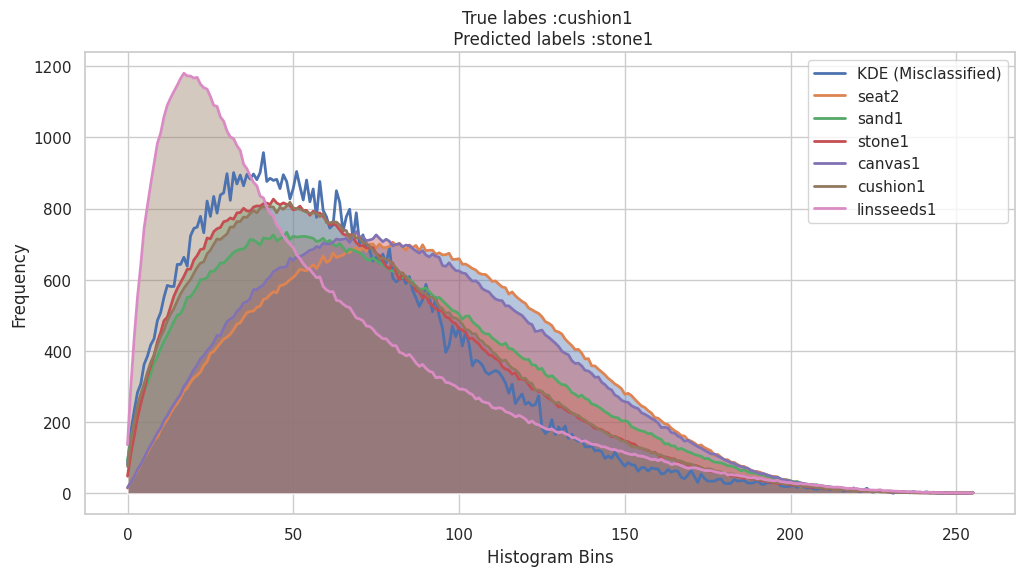


--------------------------------------



In [ ]:
print("Metrics for training data based on Euclidean distance distance")
print()
euclidean_distance(train_hist2, avg_df2)
print()
print("--------------------------------------")
print()
print("Metrics for validation data based on Euclidean distance distance")
print()
euclidean_distance(val_hist2, avg_df2)
print()
print("--------------------------------------")
print()

### Evaluate the metrics over training and validation data and visualize the misclassified samples based on the correlation coefficient distance

Metrics for training data based on chi squared distance

Accuracy: 0.7569444444444444
Recall: 0.7569444444444445
Precision: 0.7312385823894777


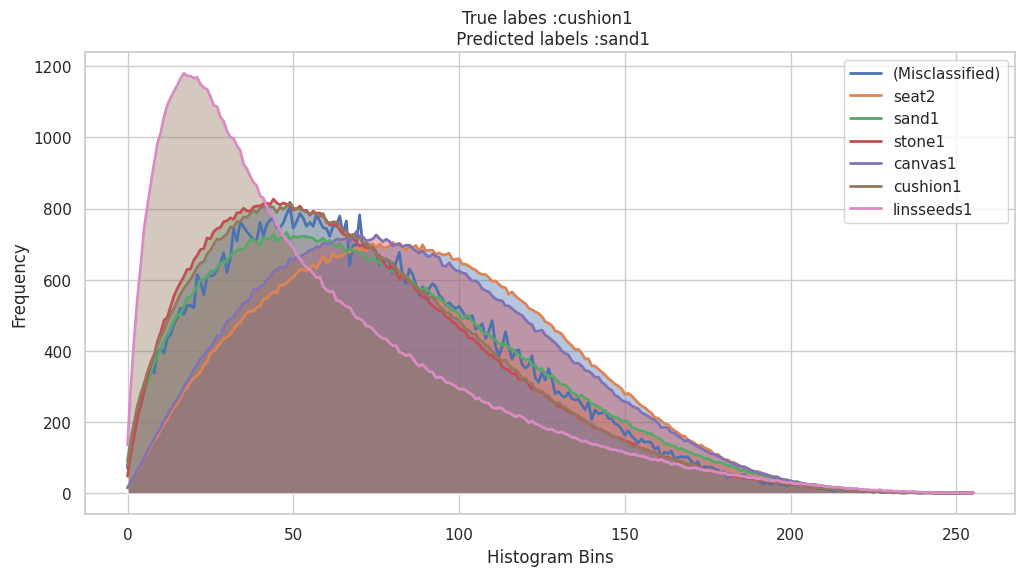


--------------------------------------

Metrics for validation data based on chi squared distance

Accuracy: 0.7777777777777778
Recall: 0.7777777777777778
Precision: 0.6694444444444444


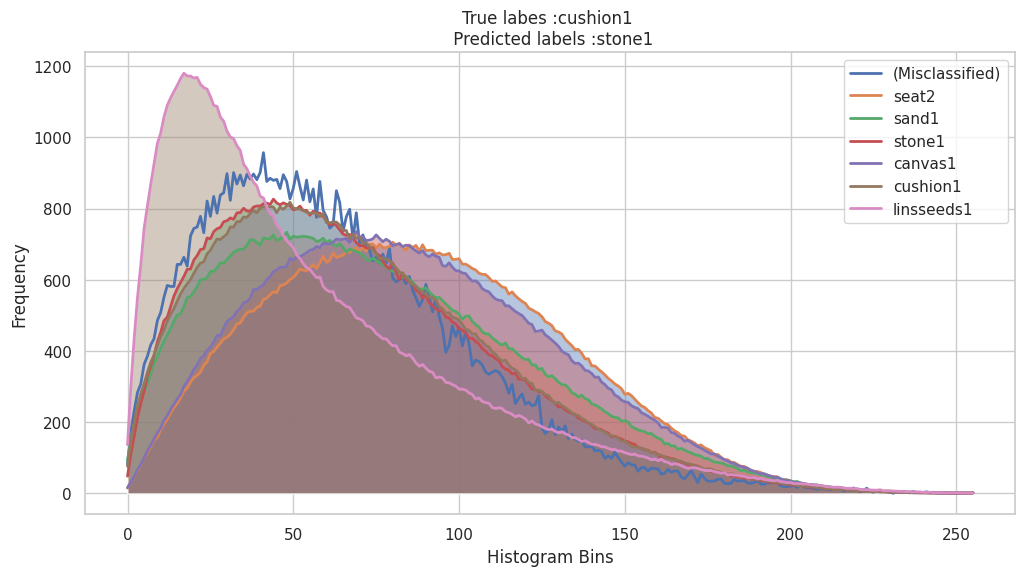


--------------------------------------



In [ ]:
print("Metrics for training data based on chi squared distance")
print()
corr_coefficient(train_hist2, avg_df2)
print()
print("--------------------------------------")
print()
print("Metrics for validation data based on chi squared distance")
print()
corr_coefficient(val_hist2, avg_df2)
print()
print("--------------------------------------")
print()

### Evaluate the chi squared distance , correlation coefficient , euclidean distance over the testing data

Metrics for Testing data based on Chi Squared  distance

Accuracy: 0.65
Recall: 0.65
Precision: 0.6450702075702075


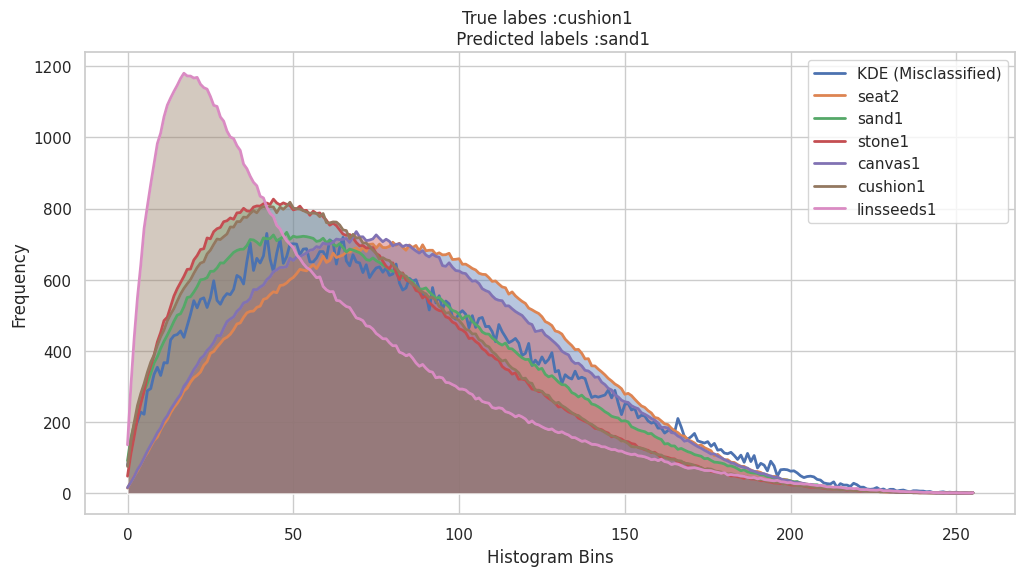


--------------------------------------

Metrics for Testing data based on Euclidean distance

Accuracy: 0.6333333333333333
Recall: 0.6333333333333333
Precision: 0.6140873015873016


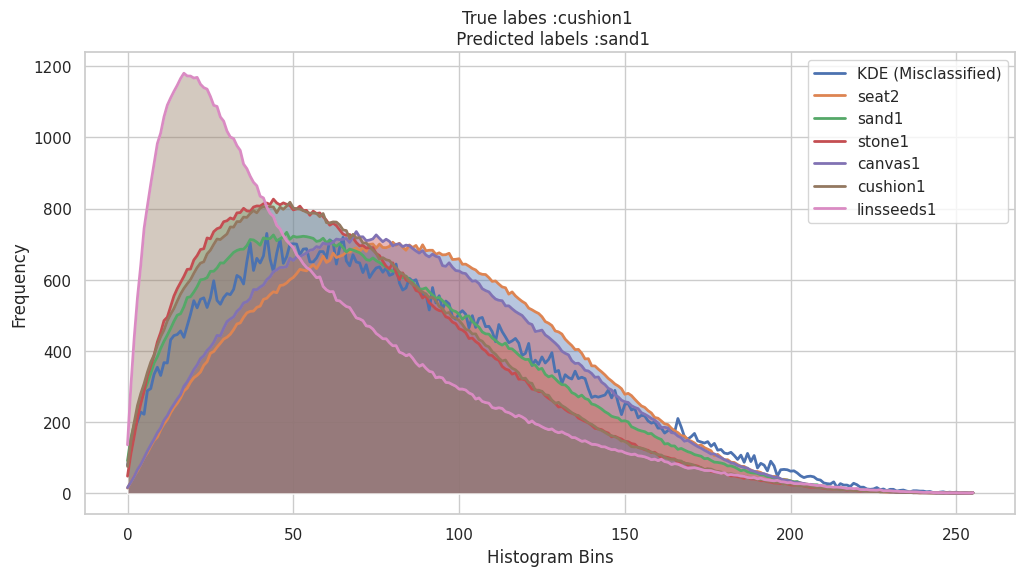


--------------------------------------

Metrics for Testing data based on Correlation Coefficient

Accuracy: 0.65
Recall: 0.65
Precision: 0.6450702075702075


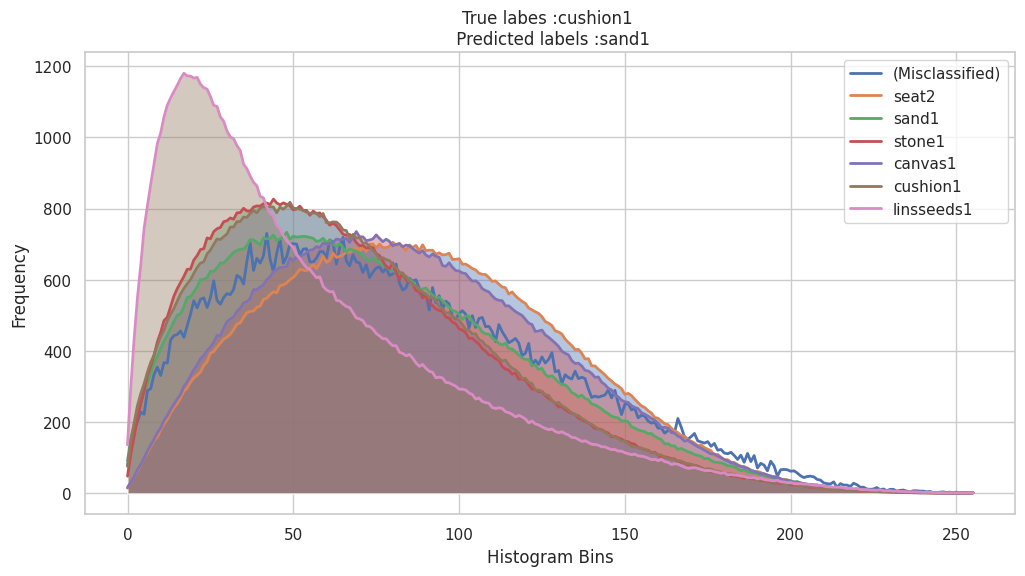

In [ ]:
print("Metrics for Testing data based on Chi Squared  distance")
print()
chi_squared_distance(test_hist2, avg_df2)
print()
print("--------------------------------------")
print()
print("Metrics for Testing data based on Euclidean distance")
print()
euclidean_distance(test_hist2, avg_df2)
print()
print("--------------------------------------")
print()
print("Metrics for Testing data based on Correlation Coefficient")
print()
corr_coefficient(test_hist2, avg_df2)

## Level 3

### Plot the KDEs for each category of the training data

In [ ]:
data = {
    'Seat2': seat2_avg_hist_train3,
    'Sand1': sand1_avg_hist_train3,
    'Stone1': stone1_avg_hist_train3,
    'Canvas1': canvas1_avg_hist_train3,
    'Cushion1': cushion1_avg_hist_train3,
    'Linsseeds1': linsseeds1_avg_hist_train3,
}

df = pd.DataFrame(data)


In [ ]:
df

Seat2      Sand1     Stone1    Canvas1   Cushion1  Linsseeds1
0     4.125000   5.458333   7.833333   6.625000   7.958333   11.250000
1     5.666667  11.708333  13.041667  10.625000  11.625000   24.708333
2     6.291667  17.500000  20.541667  16.000000  17.500000   34.083333
3    10.041667  21.083333  24.958333  19.500000  21.541667   46.375000
4    11.750000  28.208333  33.041667  24.208333  26.583333   56.458333
..         ...        ...        ...        ...        ...         ...
251   0.333333   0.208333   0.250000   0.041667   0.583333    0.708333
252   0.166667   0.291667   0.333333   0.208333   0.458333    0.375000
253   0.083333   0.291667   0.208333   0.083333   0.416667    0.250000
254   0.083333   0.083333   0.083333   0.125000   0.291667    0.375000
255   1.083333   1.083333   1.041667   1.041667   1.291667    1.250000

[256 rows x 6 columns]

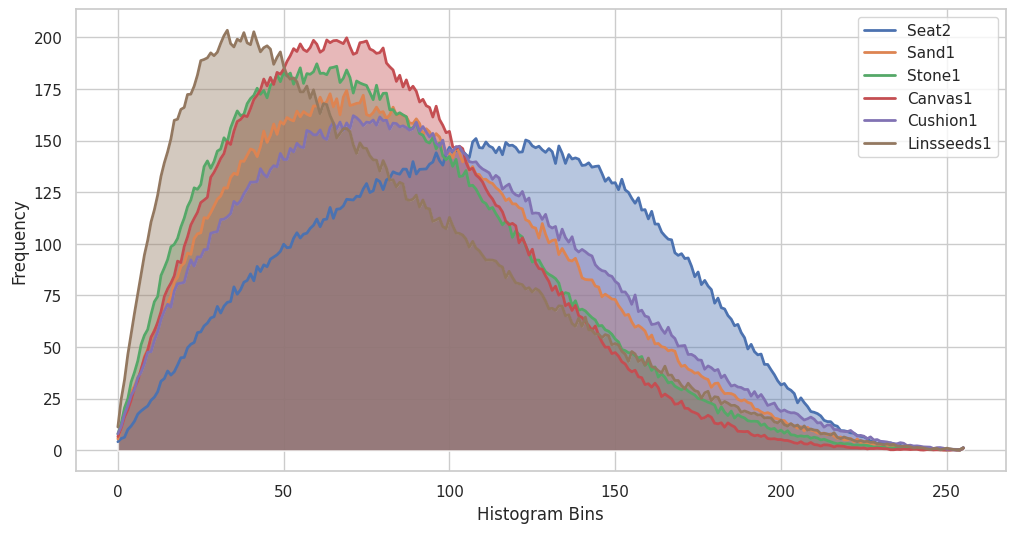

In [ ]:
plot_hist(df)

### Evaluate the metrics over training and validation data and visualize the misclassified samples based on the chi squared distance

Metrics for training data based on chi squared distance

Accuracy: 0.8611111111111112
Recall: 0.8611111111111112
Precision: 0.8737971971667623


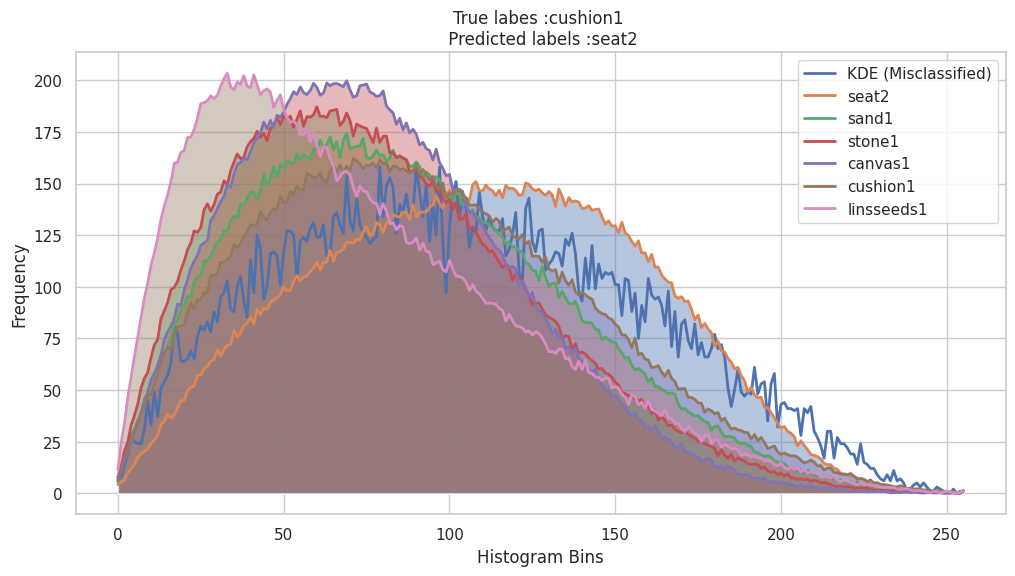


--------------------------------------

Metrics for validation data based on chi squared distance

Accuracy: 0.7777777777777778
Recall: 0.7777777777777778
Precision: 0.7962962962962963


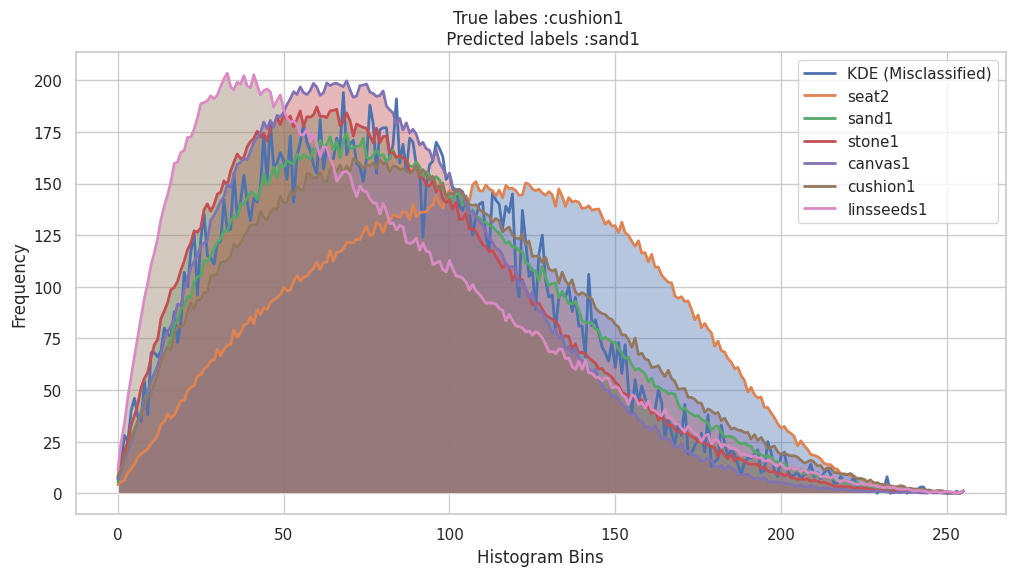


--------------------------------------



In [ ]:
print("Metrics for training data based on chi squared distance")
print()
chi_squared_distance(train_hist3, avg_df3)
print()
print("--------------------------------------")
print()
print("Metrics for validation data based on chi squared distance")
print()
chi_squared_distance(val_hist3, avg_df3)
print()
print("--------------------------------------")
print()

### Evaluate the metrics over training and validation data and visualize the misclassified samples based on the euclidean distance

Metrics for training data based on Euclidean distance distance

Accuracy: 0.8819444444444444
Recall: 0.8819444444444445
Precision: 0.8970169264286912


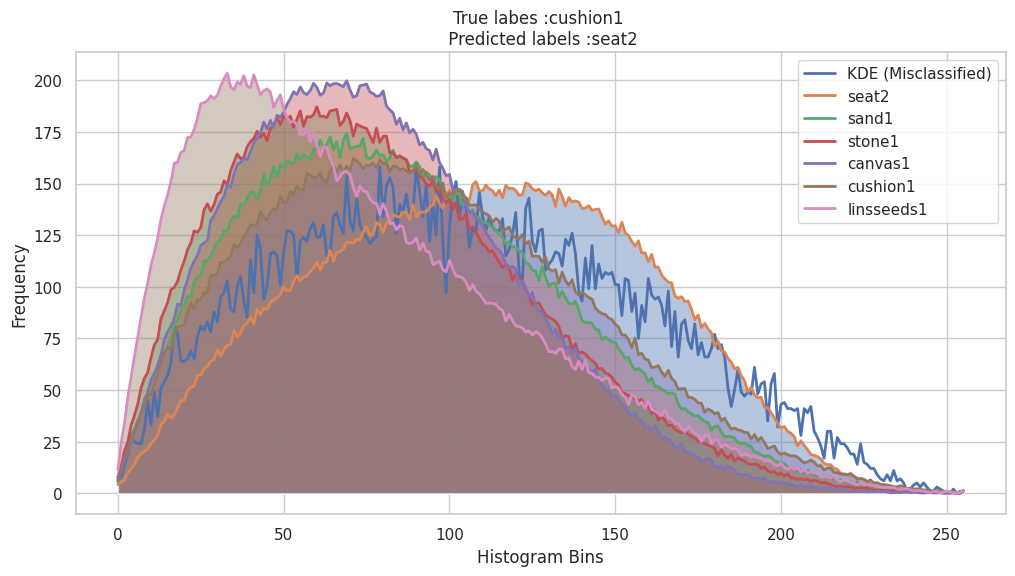


--------------------------------------

Metrics for validation data based on Euclidean distance distance

Accuracy: 0.7777777777777778
Recall: 0.7777777777777777
Precision: 0.8166666666666668


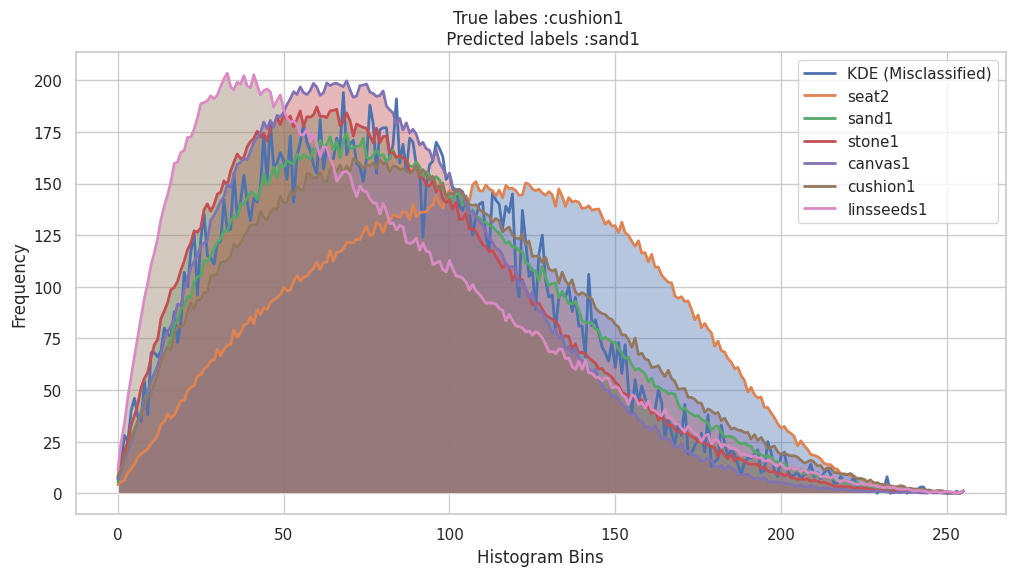


--------------------------------------



In [ ]:
print("Metrics for training data based on Euclidean distance distance")
print()
euclidean_distance(train_hist3, avg_df3)
print()
print("--------------------------------------")
print()
print("Metrics for validation data based on Euclidean distance distance")
print()
euclidean_distance(val_hist3, avg_df3)
print()
print("--------------------------------------")
print()

### Evaluate the metrics over training and validation data and visualize the misclassified samples based on the correlation coefficient distance

Metrics for training data based on chi squared distance

Accuracy: 0.8611111111111112
Recall: 0.8611111111111112
Precision: 0.8737971971667623


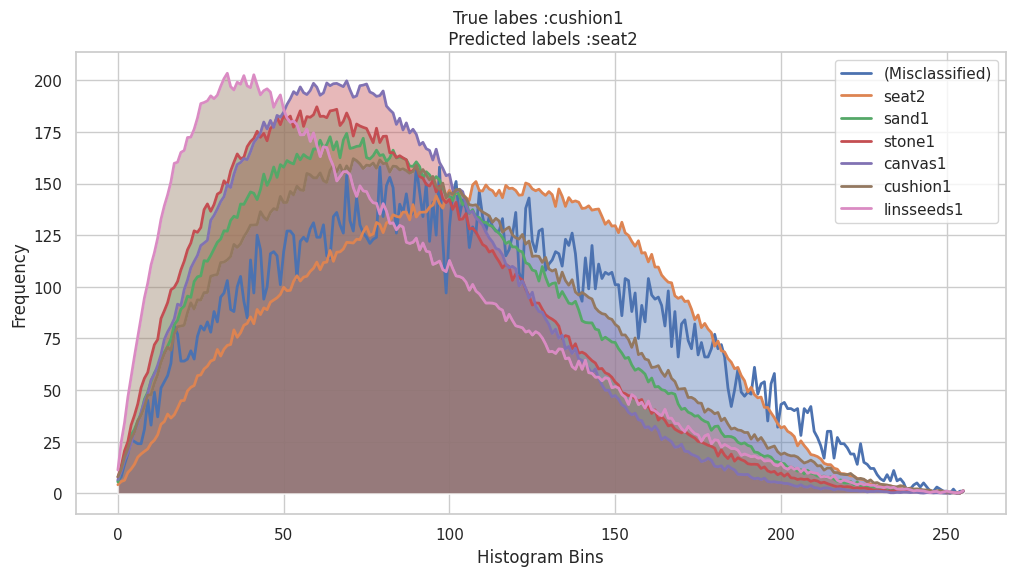


--------------------------------------

Metrics for validation data based on chi squared distance

Accuracy: 0.7777777777777778
Recall: 0.7777777777777778
Precision: 0.7962962962962963


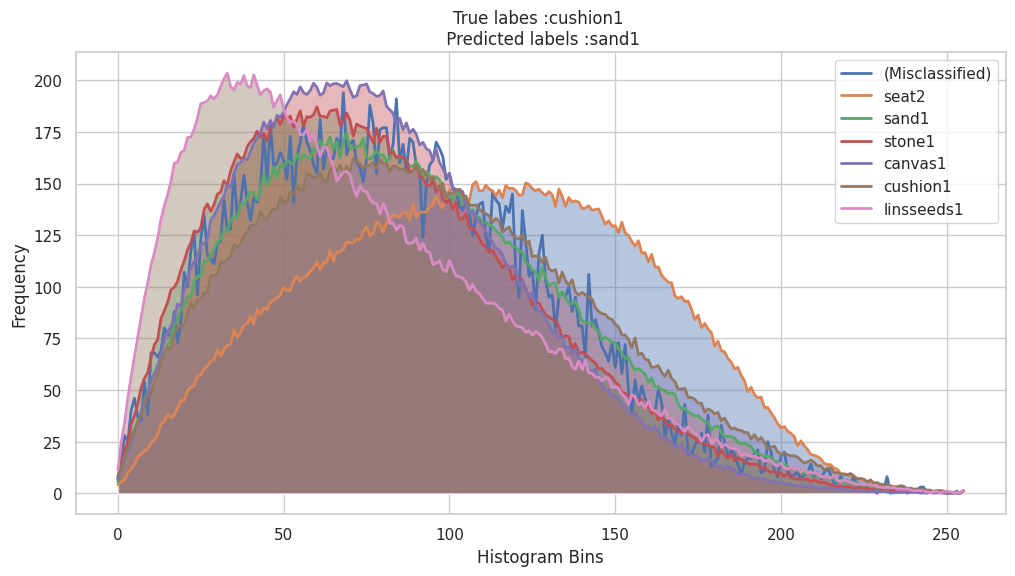


--------------------------------------



In [ ]:
print("Metrics for training data based on chi squared distance")
print()
corr_coefficient(train_hist3, avg_df3)
print()
print("--------------------------------------")
print()
print("Metrics for validation data based on chi squared distance")
print()
corr_coefficient(val_hist3, avg_df3)
print()
print("--------------------------------------")
print()

### Evaluate the chi squared distance , correlation coefficient , euclidean distance over the testing data

Metrics for Testing data based on Chi Squared  distance

Accuracy: 0.8666666666666667
Recall: 0.8666666666666667
Precision: 0.865007215007215


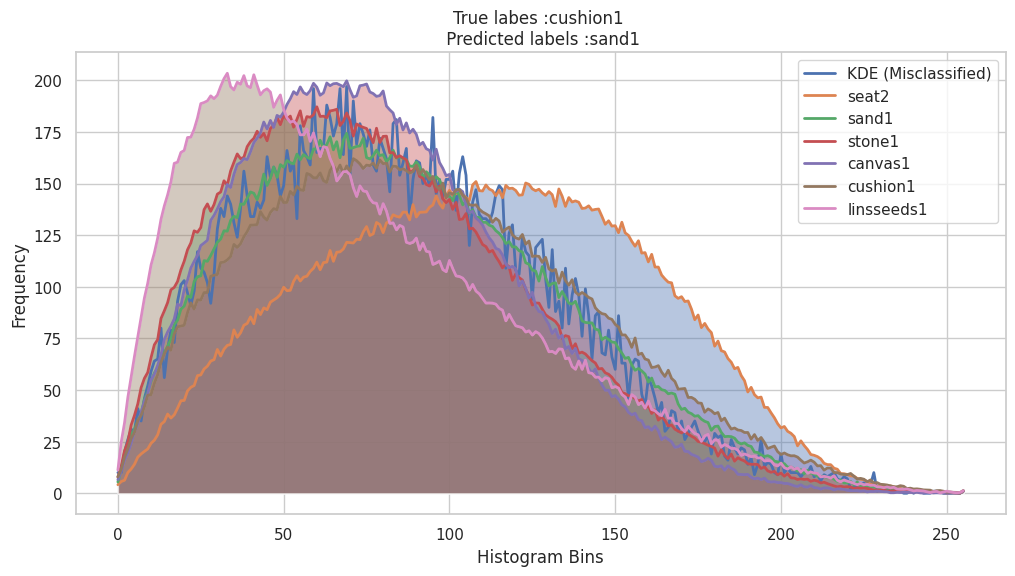


--------------------------------------

Metrics for Testing data based on Euclidean distance

Accuracy: 0.8833333333333333
Recall: 0.8833333333333333
Precision: 0.8975468975468975


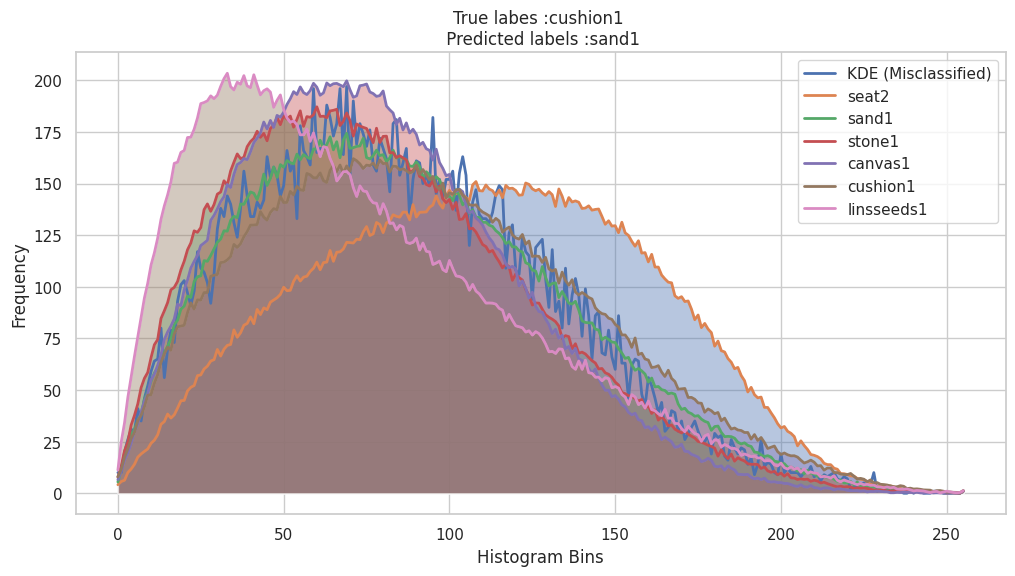


--------------------------------------

Metrics for Testing data based on Correlation Coefficient

Accuracy: 0.8666666666666667
Recall: 0.8666666666666667
Precision: 0.865007215007215


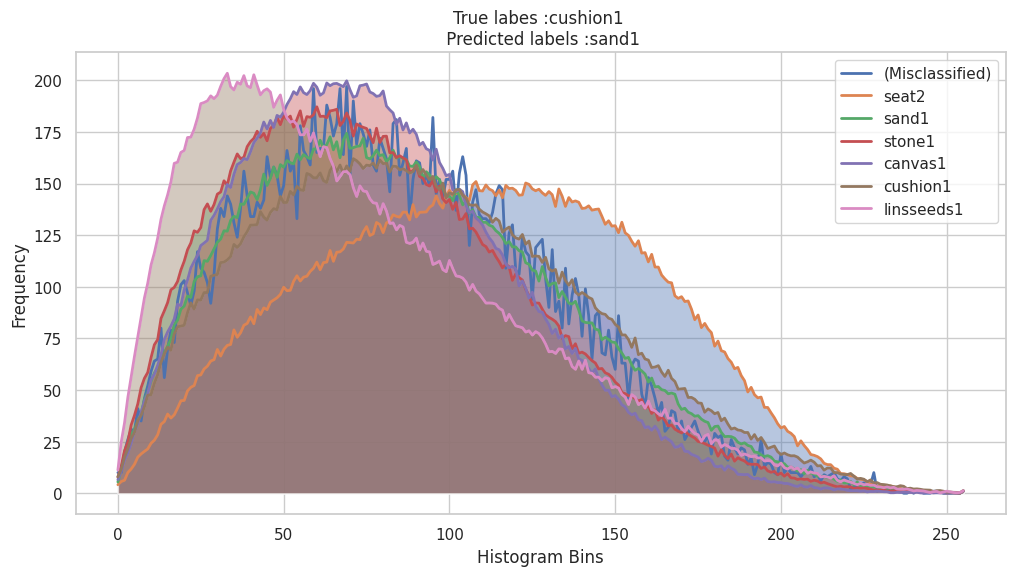

In [ ]:
print("Metrics for Testing data based on Chi Squared  distance")
print()
chi_squared_distance(test_hist3, avg_df3)
print()
print("--------------------------------------")
print()
print("Metrics for Testing data based on Euclidean distance")
print()
euclidean_distance(test_hist3, avg_df3)
print()
print("--------------------------------------")
print()
print("Metrics for Testing data based on Correlation Coefficient")
print()
corr_coefficient(test_hist3, avg_df3)

## Function to visualise the metrics to be more understandable

In [ ]:
def plot_data_metrics(acc_lists, pr_lists, re_lists, datasets):
    fig, axes = plt.subplots(len(datasets), 1, figsize=(8, 4 * len(datasets)))

    x = range(len(acc_lists[0]))  # Assuming all datasets have the same number of data points

    bar_width = 0.2
    opacity = 0.7
    distance = 0.1

    for i, dataset in enumerate(datasets):
        ax = axes[i]

        for metric_lists, label in zip([acc_lists, pr_lists, re_lists], ['Accuracy', 'Precision', 'Recall']):
            values = metric_lists[i]
            ax.bar(x, [val * 100 for val in values], width=bar_width, label=label, align='center', alpha=opacity)
            x = [xi + distance for xi in x]

        ax.set_xticks([xi - 1.5 * distance for xi in x])
        ax.set_xticklabels(['Chi', 'Euc', 'Cor', 'MLP'])
        ax.set_xlabel('Distance Metric')
        ax.set_title(f'{dataset} Data Metrics')
        ax.legend()

        # Display the values on top of the bars
        for xi, yi in zip(x, values):
            ax.text(xi - 0.075, yi * 100 + 1, f'{yi * 100:.1f}', ha='center', fontsize=8)

    plt.tight_layout()
    plt.show()

## Visualize the chi squared, euclidean, correlation distances with the MLP model for the training, validation and testing data for level 1 images

In [ ]:
# Level 1
acc_train_Level_1 = [0.875, 0.9027, 0.875, 1]
acc_val_Level_1 = [0.9166, 0.9444, 0.9166, 1]
acc_test_Level_1 = [0.8333, 0.8666, 0.8333, 0.95]

pr_train_Level_1 = [0.8749, 0.9027, 0.8749, 1]
pr_val_Level_1 = [0.9166, 0.9444, 0.9166, 1]
pr_test_Level_1 = [0.8333, 0.8666, 0.8333, 0.9501]

re_train_Level_1 = [0.8825, 0.9133, 0.8825, 1]
re_val_Level_1 = [0.9246, 0.9484, 0.9246, 1]
re_test_Level_1 = [0.8472, 0.8778, 0.8472, 0.9570]

# Organize data into lists
acc_lists_Level_1 = [acc_train_Level_1, acc_val_Level_1, acc_test_Level_1]
pr_lists_Level_1 = [pr_train_Level_1, pr_val_Level_1, pr_test_Level_1]
re_lists_Level_1 = [re_train_Level_1, re_val_Level_1, re_test_Level_1]

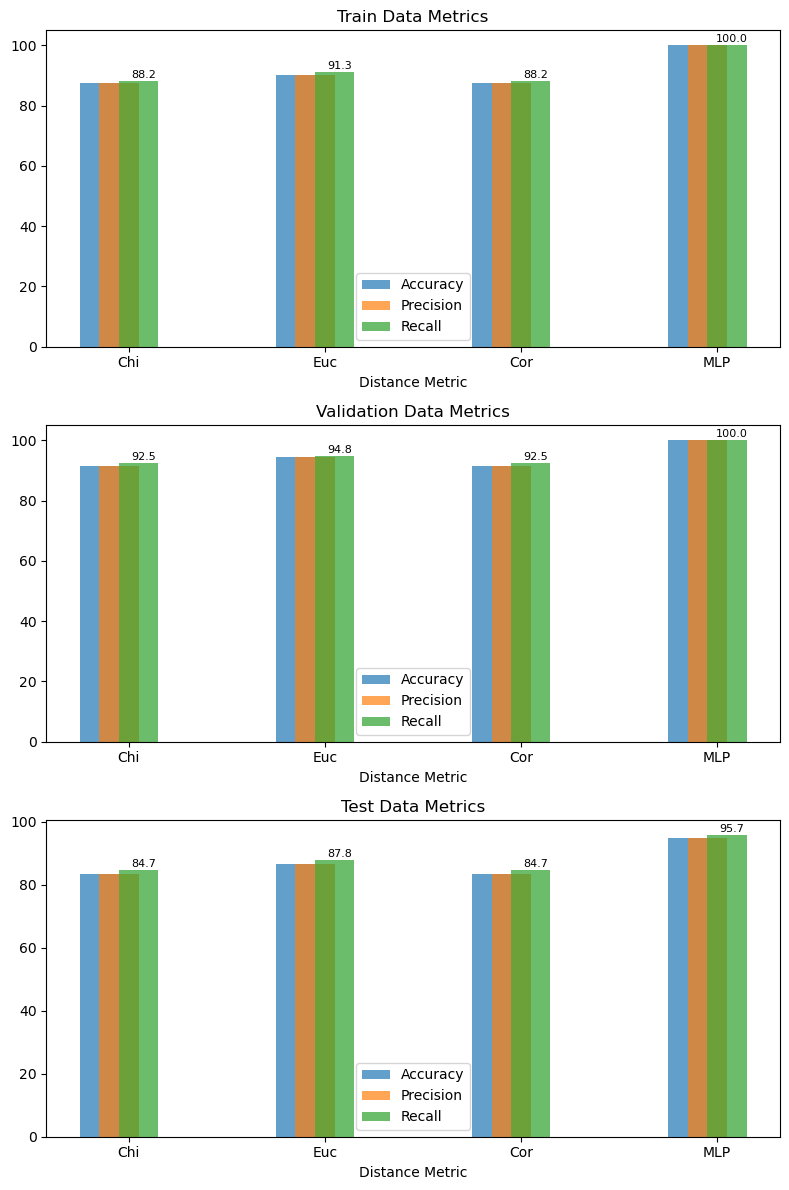

In [ ]:
datasets = ['Train', 'Validation', 'Test' ]
plot_data_metrics(acc_lists_Level_1 ,  pr_lists_Level_1 , re_lists_Level_1 , datasets)

## Visualize the chi squared, euclidean, correlation distances with the MLP model for the training, validation and testing data for level 2 images

In [ ]:
# Level 2
acc_train_Level_2 = [0.7569, 0.7361, 0.7569, 1]
acc_val_Level_2 = [0.7778, 0.75, 0.7778, 1]
acc_test_Level_2 = [0.65, 0.6333, 0.65, 0.95]

pr_train_Level_2 = [0.7569, 0.7361, 0.7569, 1]
pr_val_Level_2 = [0.7778, 0.75, 0.7778, 1]
pr_test_Level_2 = [0.65, 0.6333, 0.65, 0.9501]

re_train_Level_2 = [0.7312, 0.7101, 0.7312, 1]
re_val_Level_2 = [0.6694, 0.6620, 0.6694, 1]
re_test_Level_2 = [0.6450, 0.6140, 0.6450, 0.9570]

acc_lists_Level_2 = [acc_train_Level_2, acc_val_Level_2, acc_test_Level_2]
pr_lists_Level_2 = [pr_train_Level_2, pr_val_Level_2, pr_test_Level_2]
re_lists_Level_2 = [re_train_Level_2, re_val_Level_2, re_test_Level_2]


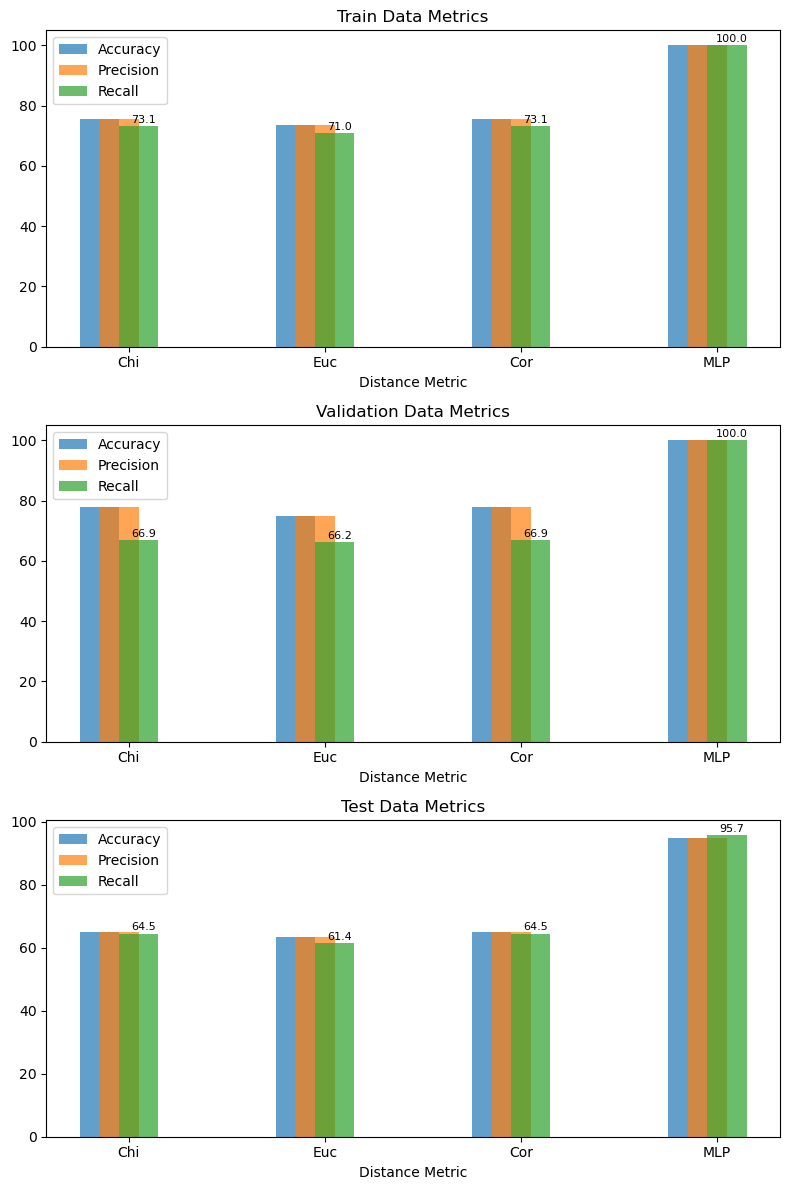

In [ ]:
plot_data_metrics(acc_lists_Level_2 ,  pr_lists_Level_2 , re_lists_Level_2 , datasets)

## Visualize the chi squared, euclidean, correlation distances with the MLP model for the training, validation and testing data for level 3 images

In [ ]:
# Level 3
acc_train_Level_3 = [0.8612, 0.8819, 0.8612, 1]
acc_val_Level_3 = [0.7778, 0.7778, 0.7778, 1]
acc_test_Level_3 = [0.8667, 0.8833, 0.8667, 0.95]

pr_train_Level_3 = [0.8612, 0.8819, 0.8612, 1]
pr_val_Level_3 = [0.7778, 0.7778, 0.7778, 1]
pr_test_Level_3 = [0.8667, 0.8833, 0.8667, 0.9501]

re_train_Level_3 = [0.8737, 0.8970, 0.8737, 1]
re_val_Level_3 = [0.7962, 0.8168, 0.7962, 1]
re_test_Level_3 = [0.8650, 0.8975, 0.8650, 0.9570]

acc_lists_Level_3 = [acc_train_Level_3, acc_val_Level_3, acc_test_Level_3]
pr_lists_Level_3 = [pr_train_Level_3, pr_val_Level_3, pr_test_Level_3]
re_lists_Level_3 = [re_train_Level_3, re_val_Level_3, re_test_Level_3]


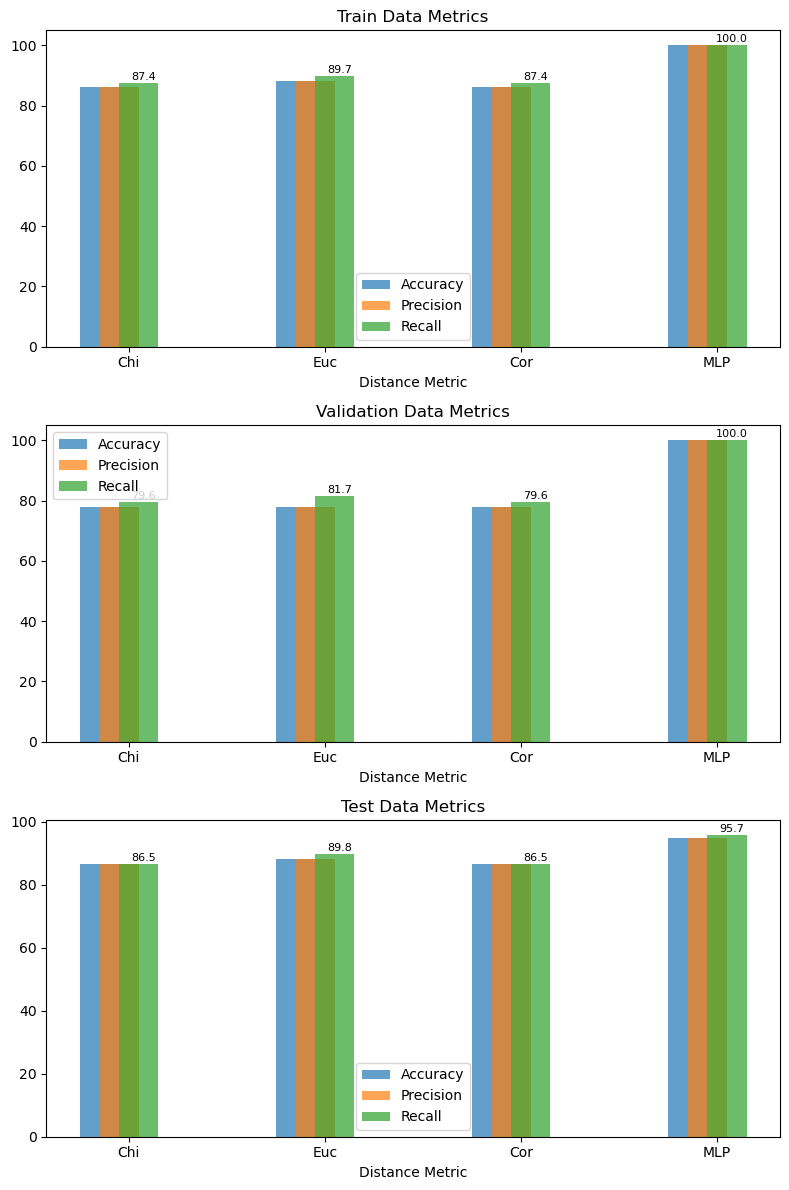

In [ ]:
plot_data_metrics(acc_lists_Level_3 ,  pr_lists_Level_3 , re_lists_Level_3 , datasets)

## Discussion

**In Level 1 the Euclidean distance is the best method between all learning free methods**
****
**In Level 2 the Chi squared distance is the best between the learning free methods**
****
**In Level 3 the Euclidean distance returns to be the best learning free method**
****
**The level 3 metrics are better than the level 1 and 2**
****
**The Multilayer perceptron models is more better than the best learning free method**